# 社群媒體分析專案：**PTT八卦版以巴衝突關鍵字的輿論分析** 

**Team: 邱邱LAB**  

**Members: 莊家綺、韓亞軒、周韻文、吳蕎安**

**YouTube影片連結：https://youtu.be/RcicEVu4ESA?si=rQmx5vgU3KxYaS_k**

### A. 動機和分析目的

- **研究動機：**  
PTT是台灣最大的網路社群之一，對國際議題的討論尤其活躍。其中，以色列和巴勒斯坦之間的長期衝突，一直是PTT上引發激烈討論的話題之一。該衝突不僅牽動著中東地區的政治格局，也觸及到全球的人權、宗教信仰、地區安全等多個層面。因此，深入了解PTT上關於巴勒斯坦問題的討論與輿論分析，對於我們理解台灣網路社群對於國際議題的關注程度、態度與看法具有重要意義。

- **研究目的：**  
本研究旨在通過對PTT上關於巴勒斯坦問題討論的文本分析，探究台灣網路使用者對於該議題的關注度、立場傾向以及意見分歧，以期能夠深入了解台灣網路社群在國際政治議題上的輿論動向，並為相關研究提供新的視角和資料支持。

### B. 資料集描述

**資料來源：**
+ 工作流程平台蒐集PTT 八卦版(Gossiping)、政黑版（HatePolitics）文章
+ 關鍵字：「以巴衝突」、「以巴戰爭」
+ 時間： 2022/01/01~2024/04/16
+ 資料筆數：共 986 篇文章

### C/D. 資料分析與解釋

大綱：

1. 利用jieba進行前資料處理並產生文字雲
    - 1.1 資料清理、斷詞處理
    - 1.2 更新斷詞及停用辭典
    - 1.3 比較清理前後的文字雲  
2. 利用lexicon-base進行情緒分析
    - 2.1 正負向情緒詞彙頻率折線圖
    - 2.2 正負向情緒詞彙比例折線圖
    - 2.3 文章為單位的情緒分析
    - 2.4 情緒代表字長條圖 
    - 2.5 探討折線圖異常處(文字雲、字詞關係分析)
3. 利用snowNLP進行情緒分析 
    - 3.1 情緒分數計算
    - 3.2 負面詞彙文字雲
    - 3.3 (補充)使用LLM Information Extraction進行情緒分析
4. 找出重要詞彙 - 以TF/IDF為例
    - 4.1 TF/IDF
    - 4.2 檢視結果  
5. 透過結巴斷詞與N-gram幫助建立斷詞字典
    - 5.1 Bigram
    - 5.2 Bigram視覺化  
6. Pairwise correlation
    - 6.1 使用詞彙關係圖畫出以詞頻前50為節點且相關性高於0.4的組合   
7. 建立Ngram預測模型  
8. LDA 主題模型
    - 8.1 LDA 主題模型
    - 8.2 查看 LDA 主題代表字
    - 8.3 透過指標找出最佳主題數
    - 8.4 視覺化呈現
    - 8.5 主題分佈的應用，搭配其他文章資訊
9. BERT Text Clustering
    - 9.1 使用 BERTopic 建立主題模型
    - 9.2 查看各主題的詞彙分佈
10. 使用NER結果繪圖
    - 10.1 查看各組織(ORG)之間的關係
    - 10.2 查看各國家或地區(GPE)之間的關係

11. 社群網路分析
    - 11.1 查看發文者與留言者關係
    - 11.2 查看網友之間的關係
    - 11.3 Measures on graph

## 0. 套件安裝 

In [28]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud 
import jieba
%matplotlib inline
import numpy as np
import re
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
plt.rcParams['font.sans-serif']=['SimHei'] #使 matplotilb 中文能正常顯示
fprop = fm.FontProperties(fname="./SourceHanSansTW-Regular.otf")
FontPath = 'SourceHanSansTW-Regular.otf' # 設定字型
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

## 1. 利用jieba進行前資料處理並產生文字雲

讀取ptt檔案sa_project1.csv

In [30]:
df = pd.read_csv("raw_data/sa_project1.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head()

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
1  https://www.ptt.cc/bbs/Gossiping/M.1645750990....   
2  https://www.ptt.cc/bbs/Gossiping/M.1645805743....   
3  https://www.ptt.cc/bbs/Gossiping/M.1659841623....   
4  https://www.ptt.cc/bbs/Gossiping/M.1659842782....   

                       artTitle     artDate    artPoster artCatagory  \
0             [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21        forng   Gossiping   
1           [問卦]去年阿富汗今年烏克蘭明年？？？  2022-02-25      ig49999   Gossiping   
2      [問卦]以色列猶太可以打巴基,俄國不能打烏克蘭?  2022-02-26      bra6617   Gossiping   
3     [爆卦]以巴衝突，巴勒斯坦24死，以轟400枚飛彈  2022-08-07      win1130   Gossiping   
4  Re:[爆卦]以巴衝突，巴勒斯坦24死，以轟400枚飛彈  2022-08-07  around14358   Gossiping   

                                          artContent  \
0  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
1  如題\n\n現在美國支撐的勢力逐漸瓦解\n\n美國上個世紀幫太多國家打仗了\n\n以巴衝突 ...   
2  之前以色列打巴基斯坦,\n\n不讓巴勒斯坦民?齋月期間前往聖殿山祈禱\n\n爆發大規模衝突,...   
3  https://youtu.be/x2BgAVgAhCY\n希望「\n國際社會\n」能出來譴...   
4  看了一下這影片，這中天新聞的報導在畫面右方寫"巴基斯坦"加薩現場直擊。\n"巴基斯坦"有加薩...   

                                          artComment             e_ip  \
0  [{"cmtStatus": "→", "cmtPoster": "stayawesome"...     83.244.63.14   
1  [{"cmtStatus": "→", "cmtPoster": "bill403777",...  223.140.236.187   
2  [{"cmtStatus": "推", "cmtPoster": "saber0408", ...   104.200.129.85   
3  [{"cmtStatus": "→", "cmtPoster": "greensaru", ...    118.231.201.7   
4  [{"cmtStatus": "推", "cmtPoster": "randolph80",...    112.78.93.193   

     insertedDate dataSource  
0  2022/1/22 1:03        ptt  
1  2022/2/26 0:44        ptt  
2  2022/2/26 1:04        ptt  
3  2022/8/10 1:17        ptt  
4  2022/8/10 1:17        ptt

### 1.1 資料清理、斷詞處理

資料清理

In [31]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

artUrl  \
0    https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
1    https://www.ptt.cc/bbs/Gossiping/M.1645750990....   
2    https://www.ptt.cc/bbs/Gossiping/M.1645805743....   
3    https://www.ptt.cc/bbs/Gossiping/M.1659841623....   
4    https://www.ptt.cc/bbs/Gossiping/M.1659842782....   
..                                                 ...   
982  https://www.ptt.cc/bbs/HatePolitics/M.17091907...   
983  https://www.ptt.cc/bbs/HatePolitics/M.17102451...   
984  https://www.ptt.cc/bbs/HatePolitics/M.17109951...   
985  https://www.ptt.cc/bbs/HatePolitics/M.17111693...   
986  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   

                         artTitle     artDate  \
0               [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
1             [問卦]去年阿富汗今年烏克蘭明年？？？  2022-02-25   
2        [問卦]以色列猶太可以打巴基,俄國不能打烏克蘭?  2022-02-26   
3       [爆卦]以巴衝突，巴勒斯坦24死，以轟400枚飛彈  2022-08-07   
4    Re:[爆卦]以巴衝突，巴勒斯坦24死，以轟400枚飛彈  2022-08-07   
..                            ...         ...   
982        [新聞]拜登要求以色列就使用美國武器提供保證  2024-02-29   
983             [黑特]現在正在第三次世界大戰了吧  2024-03-12   
984                [討論]現在很像當年二戰前？  2024-03-21   
985              [討論]恐怖份子跟俄羅斯要挺誰？  2024-03-23   
986        [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   

                                            artContent  \
0    是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
1    如題\n\n現在美國支撐的勢力逐漸瓦解\n\n美國上個世紀幫太多國家打仗了\n\n以巴衝突 ...   
2    之前以色列打巴基斯坦,\n\n不讓巴勒斯坦民?齋月期間前往聖殿山祈禱\n\n爆發大規模衝突,...   
3    https://youtu.be/x2BgAVgAhCY\n希望「\n國際社會\n」能出來譴...   
4    看了一下這影片，這中天新聞的報導在畫面右方寫"巴基斯坦"加薩現場直擊。\n"巴基斯坦"有加薩...   
..                                                 ...   
982  1.新聞網址︰\nhttp://tinyurl.com/2s4dhz28\n2.新聞來源︰\...   
983  依照現在這個情況算是世界大戰吧\n從烏克蘭不可能投降那刻開始\n歐洲那幾個平常養尊處優的幾個...   
984  二戰前有些地方跟現在很像\n\n像是極端主義的崛起，中東、歐美的激進派崛起，包括被極左派激起...   
985  某些台灣人喜歡二分法。\n\n每次國際有人發生衝突台灣人就跟玩狼人殺一樣，通常會有兩個預言家...   
986  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   

                                              sentence  
0    是這樣啦。去巴勒斯坦控制區，。希伯崙想說來觀光一下。怎麼遇到民眾朝軍隊仍汽油彈啊。太刺激了吧...  
1    如題。現在美國支撐的勢力逐漸瓦解。美國上個世紀幫太多國家打仗了。以巴衝突 朝鮮 越南。從美國...  
2    之前以色列打巴基斯坦,。不讓巴勒斯坦民?齋月期間前往聖殿山祈禱。爆發大規模衝突,有些網友還嘲...  
3                                                       
4    看了一下這影片，這中天新聞的報導在畫面右方寫"巴基斯坦"加薩現場直擊。"巴基斯坦"有加薩嗎？...  
..                                                 ...  
982  1.新聞網址︰ 2024/02/294.完整新聞內容︰陳柏吟 關鍵評論網編輯部實習生。我們想...  
983  依照現在這個情況算是世界大戰吧從烏克蘭不可能投降那刻開始歐洲那幾個平常養尊處優的幾個歐洲強國...  
984  二戰前有些地方跟現在很像。像是極端主義的崛起，中東、歐美的激進派崛起，包括被極左派激起的新納...  
985  某些台灣人喜歡二分法。。每次國際有人發生衝突台灣人就跟玩狼人殺一樣，通常會有兩個預言家，一定...  
986  1.新聞網址︰ 江國田 報導3.完整新聞標題美國不擋了！　安理會首過加薩停火決議納坦雅胡爆氣...  

[986 rows x 5 columns]

斷句的部分增加「：」

In [32]:
clear_df['sentence'] = clear_df['sentence'].str.split("[：,，。！!？?]{1,}") #增加:：
sent_df = clear_df.explode('sentence').reset_index(drop=True)
sent_df.head(10)

artUrl             artTitle  \
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....    [問卦]遇到以巴衝突ing怎麼辦？   
1  https://www.ptt.cc/bbs/Gossiping/M.1642780019....    [問卦]遇到以巴衝突ing怎麼辦？   
2  https://www.ptt.cc/bbs/Gossiping/M.1642780019....    [問卦]遇到以巴衝突ing怎麼辦？   
3  https://www.ptt.cc/bbs/Gossiping/M.1642780019....    [問卦]遇到以巴衝突ing怎麼辦？   
4  https://www.ptt.cc/bbs/Gossiping/M.1642780019....    [問卦]遇到以巴衝突ing怎麼辦？   
5  https://www.ptt.cc/bbs/Gossiping/M.1645750990....  [問卦]去年阿富汗今年烏克蘭明年？？？   
6  https://www.ptt.cc/bbs/Gossiping/M.1645750990....  [問卦]去年阿富汗今年烏克蘭明年？？？   
7  https://www.ptt.cc/bbs/Gossiping/M.1645750990....  [問卦]去年阿富汗今年烏克蘭明年？？？   
8  https://www.ptt.cc/bbs/Gossiping/M.1645750990....  [問卦]去年阿富汗今年烏克蘭明年？？？   
9  https://www.ptt.cc/bbs/Gossiping/M.1645750990....  [問卦]去年阿富汗今年烏克蘭明年？？？   

      artDate                                         artContent  \
0  2022-01-21  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
1  2022-01-21  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
2  2022-01-21  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
3  2022-01-21  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
4  2022-01-21  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
5  2022-02-25  如題\n\n現在美國支撐的勢力逐漸瓦解\n\n美國上個世紀幫太多國家打仗了\n\n以巴衝突 ...   
6  2022-02-25  如題\n\n現在美國支撐的勢力逐漸瓦解\n\n美國上個世紀幫太多國家打仗了\n\n以巴衝突 ...   
7  2022-02-25  如題\n\n現在美國支撐的勢力逐漸瓦解\n\n美國上個世紀幫太多國家打仗了\n\n以巴衝突 ...   
8  2022-02-25  如題\n\n現在美國支撐的勢力逐漸瓦解\n\n美國上個世紀幫太多國家打仗了\n\n以巴衝突 ...   
9  2022-02-25  如題\n\n現在美國支撐的勢力逐漸瓦解\n\n美國上個世紀幫太多國家打仗了\n\n以巴衝突 ...   

                       sentence  
0                          是這樣啦  
1                      去巴勒斯坦控制區  
2                    希伯崙想說來觀光一下  
3                怎麼遇到民眾朝軍隊仍汽油彈啊  
4  太刺激了吧 from JPTT on my iPhone  
5                            如題  
6                 現在美國支撐的勢力逐漸瓦解  
7                美國上個世紀幫太多國家打仗了  
8                    以巴衝突 朝鮮 越南  
9           從美國911到現在美國的態度也變化很大

初始化斷詞

In [33]:
jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')

Building prefix dict from /Users/zhuangjiaqi/Desktop/SA/SMA_2024S-main/sma_project/dict/dict.txt ...
Loading model from cache /var/folders/21/7y88t8cj1c3cjfvk2ww0y98h0000gn/T/jieba.uaf7aa1c5b2bd6d78ee0bcd6b0525dba3.cache
Loading model cost 0.229 seconds.
Prefix dict has been built successfully.


In [34]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

使用jieba進行斷詞

In [35]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

artUrl  \
0      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
1      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
1      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
2      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
2      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
...                                                  ...   
29605  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   
29606  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   
29606  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   
29606  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   
29606  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   

                     artTitle     artDate  \
0           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
1           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
1           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
2           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
2           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
...                       ...         ...   
29605  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   
29606  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   
29606  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   
29606  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   
29606  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   

                                              artContent  word  
0      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...    這樣  
1      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...  巴勒斯坦  
1      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   控制區  
2      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   希伯崙  
2      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...    觀光  
...                                                  ...   ...  
29605  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   同路人  
29606  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...    現在  
29606  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...    美國  
29606  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...    馬斯  
29606  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   同路人  

[149220 rows x 5 columns]

計算去除停用字及更新字典前的詞頻

In [36]:
freq_df = pd.DataFrame(pd.value_counts(word_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(10)

/var/folders/21/7y88t8cj1c3cjfvk2ww0y98h0000gn/T/ipykernel_13238/36027799.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df = pd.DataFrame(pd.value_counts(word_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


word  count
0   以色列   2560
1    美國   1171
2    台灣    993
3  巴勒斯坦    895
4   哈瑪斯    887
5    新聞    793
6    中國    755
7    戰爭    713
8  以巴衝突    652
9    加薩    628

繪製文字雲

In [37]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

freq_dict

{'以色列': 2560,
 '美國': 1171,
 '台灣': 993,
 '巴勒斯坦': 895,
 '哈瑪斯': 887,
 '新聞': 793,
 '中國': 755,
 '戰爭': 713,
 '以巴衝突': 652,
 '加薩': 628,
 '表示': 581,
 '支持': 552,
 '就是': 552,
 '國家': 534,
 '完整': 527,
 '沒有': 526,
 '媒體': 523,
 '他們': 486,
 '我們': 446,
 '報導': 404,
 '中共': 393,
 '現在': 386,
 '記者': 380,
 '政府': 349,
 '自己': 344,
 '國際': 341,
 '不是': 335,
 '總統': 334,
 '可能': 327,
 '一個': 324,
 '因為': 314,
 '可以': 309,
 '以巴戰爭': 304,
 '人民': 298,
 '平民': 294,
 '馬斯': 291,
 '10': 290,
 '問題': 282,
 '衝突': 274,
 '聯合國': 267,
 '世界': 267,
 '烏克蘭': 265,
 '攻擊': 265,
 '如果': 261,
 '和平': 259,
 '已經': 255,
 '認為': 249,
 '所以': 240,
 '還是': 228,
 '發生': 225,
 '行動': 221,
 '這個': 219,
 '關係': 218,
 '中東': 215,
 '網址': 214,
 '加薩走廊': 210,
 '地區': 210,
 '猶太人': 206,
 '指出': 206,
 '巴勒斯坦人': 204,
 '來源': 201,
 '這次': 195,
 '最後': 193,
 '伊朗': 193,
 '組織': 191,
 '目前': 191,
 '拜登': 188,
 '標題': 185,
 '軍事': 181,
 '襲擊': 180,
 '不可': 179,
 '進行': 179,
 '持續': 179,
 '不會': 179,
 '譴責': 178,
 '真的': 178,
 '民眾': 178,
 '大家': 178,
 '主義': 176,
 '俄羅斯': 176,
 '署名': 176,
 '安全': 17

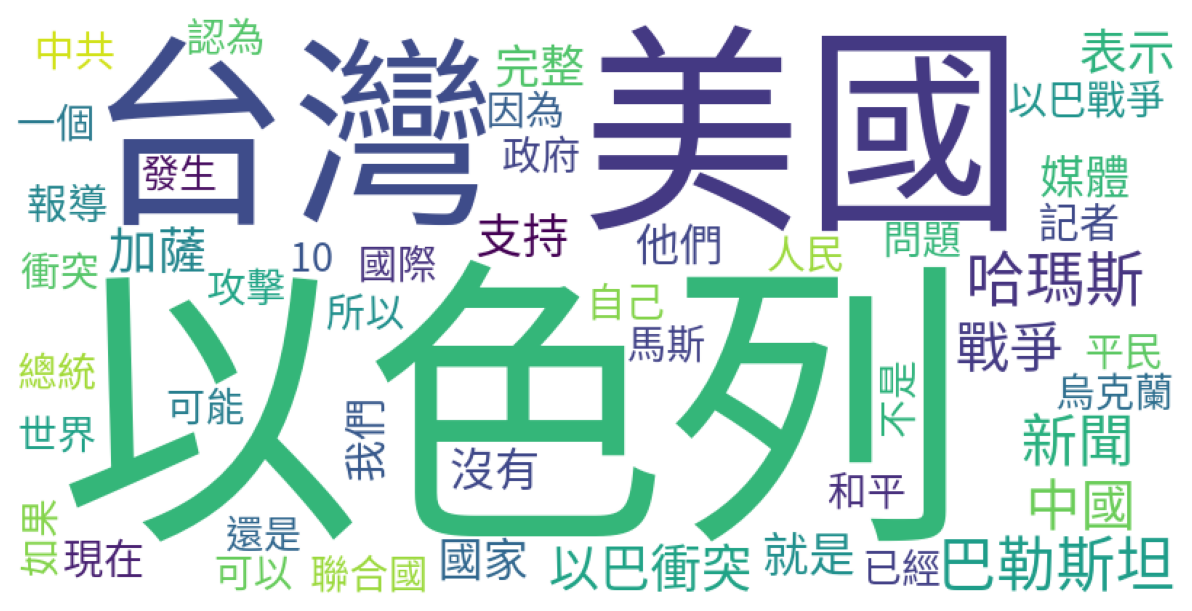

In [38]:
# 繪製文字雲
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

反覆檢查文字雲當中是否包含無關文本的關鍵字(以「10」為例)

In [39]:
filtered_df = sent_df[sent_df['sentence'].str.contains('10', na=False)]
filtered_df.head()

artUrl  \
475  https://www.ptt.cc/bbs/Gossiping/M.1696687255....   
551  https://www.ptt.cc/bbs/Gossiping/M.1696698329....   
664  https://www.ptt.cc/bbs/Gossiping/M.1696730485....   
690  https://www.ptt.cc/bbs/Gossiping/M.1696730485....   
883  https://www.ptt.cc/bbs/Gossiping/M.1696730485....   

                     artTitle     artDate  \
475  [新聞]以色列電視台稱至少40死加薩官員稱近20  2023-10-07   
551      Re:[問卦]以巴戰爭和台灣有什麼關係？  2023-10-08   
664      [新聞]哈馬斯襲以色列50年來最致命一天  2023-10-08   
690      [新聞]哈馬斯襲以色列50年來最致命一天  2023-10-08   
883      [新聞]哈馬斯襲以色列50年來最致命一天  2023-10-08   

                                            artContent  \
475  1.媒體來源:\n\n太報\n\n2.記者署名:\n\n2023-10-07 21:50 /...   
551  要說有關係，有。要說沒關係，也沒有。看你從什麼角度看。\n\n\n在俄烏戰爭所謂的春季反攻己...   
664  1.媒體來源:\n大紀元\n\n2.記者署名:\n記者張婷綜合報導\n\n3.完整新聞標題:...   
690  1.媒體來源:\n大紀元\n\n2.記者署名:\n記者張婷綜合報導\n\n3.完整新聞標題:...   
883  1.媒體來源:\n大紀元\n\n2.記者署名:\n記者張婷綜合報導\n\n3.完整新聞標題:...   

                              sentence  
475              20231007 2150  作者 莊蕙嘉  
551                    要是10月底俄軍在烏東沒有攻勢  
664  大紀元2023年10月08日訊大紀元記者張婷綜合報導週六10月7日  
690     聯合國安理會將於週日10月8日下午3點就這一事件召開緊急會議  
883                             100人受傷

In [40]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

20231007 2150  作者 莊蕙嘉
要是10月底俄軍在烏東沒有攻勢
大紀元2023年10月08日訊大紀元記者張婷綜合報導週六10月7日
聯合國安理會將於週日10月8日下午3點就這一事件召開緊急會議
100人受傷
以色列醫護人員報告的死亡人數為100人
100多人
610名巴勒斯坦人受傷
甚至最短不到10KM以巴2021年才剛戰爭過
印度神童警告世人小心10個危機
後面支援巴勒斯坦的是阿拉伯聯盟 那才開始有宗教巴勒斯坦有人訪華又不奇怪 原本10月以色列總理也要訪華勒
4完整新聞內文20231008 1345聯合報 編譯盧思綸  即時報導
新唐人北京時間2023年10月08日訊10月7日早晨
獨立時評人蔡慎坤10月7日發推文說
支持巴勒斯坦國正當防衛 全球 以巴衝突再起      20231008 2324 聯合報 編譯 高詣軒 即時報導 news agency報導
逾100人遭哈瑪斯挾持
2023年10月7日凌晨
截至台灣時間10月8日晚間8點以色列8日下午3點為止
巴人的多次抗爭亦遭到以色列軍警強力鎮壓但以色列也在10月7日宣布將發動軍事報復
擄走以國平民回加薩當人質2023年10月7日
始於10月7日清晨5點左右
2023年10月7日
以色列的911時刻引發國際輿論分裂2023年10月7日
是否有專板本板並非萬能問板三則本看板嚴格禁止政治問卦未滿30繁體中文字水桶1個月未滿20繁體中文字水桶2個月未滿10繁體中文字水桶3個月
馮昭1121009
陳承功1121008
TVBS 編輯 劉哲琪 報導20231009 1616
目前已造成雙方超過1100人死亡
另外開放乘客免費取消10月20日以前的航班
3完整新聞標題馬來西亞撥款100萬令吉 援助巴勒斯坦人民
外交部決定從巴勒斯坦人民人道主義信託基金帳戶中撥款馬幣100萬令吉
已同意從這筆基金中撥款100萬令吉約新台幣700萬元
我只知道結果就是巴勒斯坦這次完蛋了以色列強硬派早就想滅了他們特別是哈馬斯 以色列強硬派超不爽的之前以色列國內紛紛擾擾結果你現在給他們一個團結在一起滅了自己的理由爽一時 殺了幾百人未來10年內哈馬斯絕對會跟Isis一樣準備從地球上消失了白癡台灣有去中國恐攻
新唐人北京時間2023年10月10日訊被歐美定性恐怖組織的哈馬斯突襲以色列
10月7日
上週五10月6日質詢時
反觀台女124020

**結論:【停用字原因】**
+ 由於是在ppt發文，標題包括「新聞」、「情報」等類別，因此這些詞要移除
+ 轉貼新聞時內文有固定格式，需移除的字包括「發布時間」、「記者署名」、「原文內容」、「心得/評論」
+ 其他行文常用詞：「不是」、「可以」、「沒有」、「如果」、「就是」、「因為」、「一個」、「可能」、「現在」、「我們」、「他們」、「還是」等
+ 待去除的無意義數字：「10」
+ 有關以巴衝突本身的資訊：「以巴衝突」、「以巴戰爭」

### 1.2 更新斷詞及停用字詞典

更新斷詞詞典

In [41]:
jieba.add_word('哈馬斯')

重新斷詞

In [42]:
# sent_df是還沒斷詞過的df
word_df_updated = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#把長度小於1的row刪掉
word_df_updated = word_df_updated.loc[word_df_updated['word'].str.len()>1]
word_df_updated

artUrl  \
0      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
1      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
1      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
2      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
2      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
...                                                  ...   
29605  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   
29606  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   
29606  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   
29606  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   
29606  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   

                     artTitle     artDate  \
0           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
1           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
1           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
2           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
2           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
...                       ...         ...   
29605  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   
29606  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   
29606  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   
29606  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   
29606  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   

                                              artContent  word  
0      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...    這樣  
1      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...  巴勒斯坦  
1      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   控制區  
2      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   希伯崙  
2      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...    觀光  
...                                                  ...   ...  
29605  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   同路人  
29606  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...    現在  
29606  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...    美國  
29606  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   哈馬斯  
29606  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   同路人  

[149197 rows x 5 columns]

匯入停用字詞典並手動更新字典

In [43]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
# 其他停用字列表
other_stopwords = ['新聞', '情報', '發布時間', '記者署名', '原文內容', '心得', '評論', '不是', '可以', '沒有', '如果', '就是', '因為', '一個', '可能', '現在', '我們', 
                   '他們', '還是', '10', '目前', '網址', '指出', '認為', '認為', '不可', '標題', '來源', '表示', '以巴衝突', '以巴戰爭']
# 合併停用字列表
stopwords.extend(other_stopwords)

In [44]:
noStop_df = word_df_updated[~word_df_updated['word'].isin(stopwords)]
noStop_df

artUrl  \
1      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
1      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
2      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
2      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
2      https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
...                                                  ...   
29605  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   
29605  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   
29606  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   
29606  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   
29606  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   

                     artTitle     artDate  \
1           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
1           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
2           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
2           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
2           [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21   
...                       ...         ...   
29605  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   
29605  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   
29606  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   
29606  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   
29606  [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26   

                                              artContent  word  
1      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...  巴勒斯坦  
1      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   控制區  
2      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   希伯崙  
2      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...    觀光  
2      是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...    一下  
...                                                  ...   ...  
29605  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   哈馬斯  
29605  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   同路人  
29606  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...    美國  
29606  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   哈馬斯  
29606  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   同路人  

[124786 rows x 5 columns]

重新計算詞頻

In [45]:
freq_df_updated = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_updated

/var/folders/21/7y88t8cj1c3cjfvk2ww0y98h0000gn/T/ipykernel_13238/135854149.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_updated = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


word  count
0             以色列   2560
1              美國   1171
2              台灣    993
3            巴勒斯坦    895
4             哈瑪斯    887
...           ...    ...
21652          台資      1
21653     2010838      1
21654  Commission      1
21655          黑金      1
21656          毀成      1

[21657 rows x 2 columns]

繪製詞頻長條圖

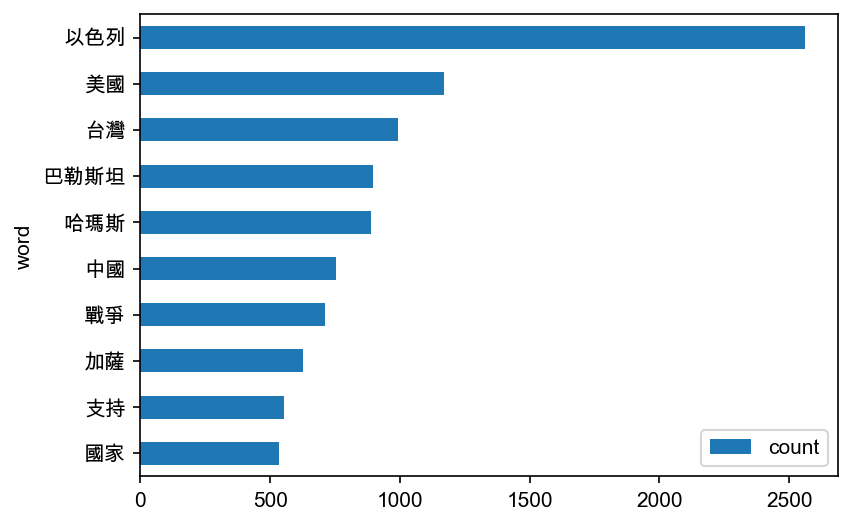

In [46]:
freq_df_updated.head(10).plot.barh(x='word', y='count').invert_yaxis()
plt.show()

重新繪製文字雲

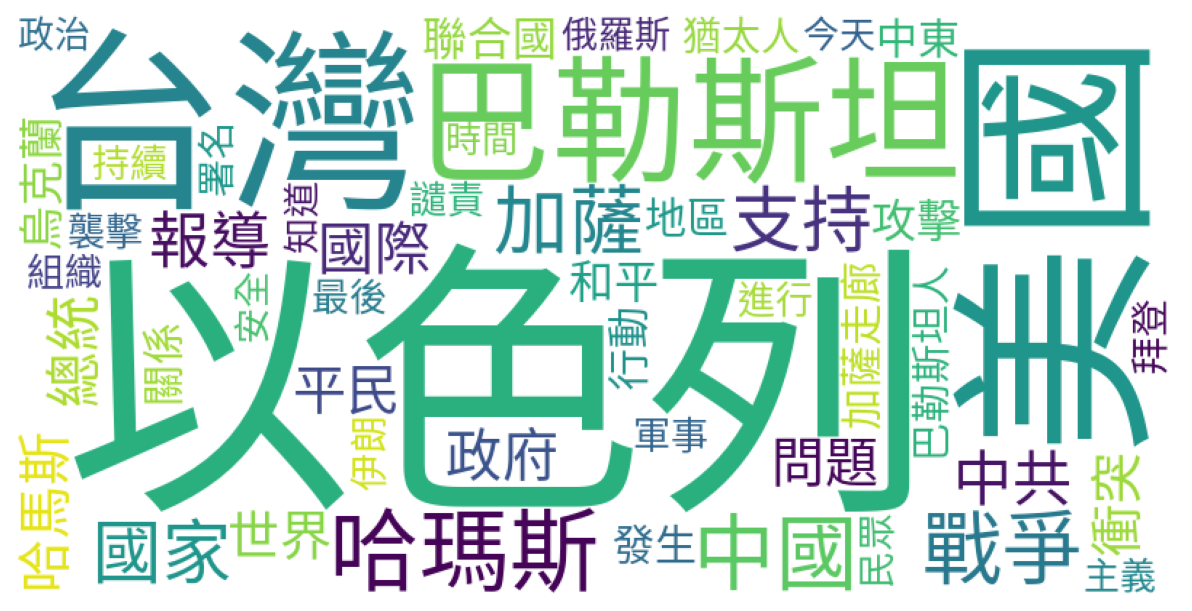

In [47]:
freq_dict_updated = freq_df_updated.set_index('word').to_dict()
freq_dict_updated = freq_dict_updated['count']

# 繪製文字雲
wordcloud_after = WordCloud(background_color='white', width=800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_after.generate_from_frequencies(freq_dict_updated)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_after)
plt.axis('off')
plt.show()

### 1.3 比較清理前後的文字雲

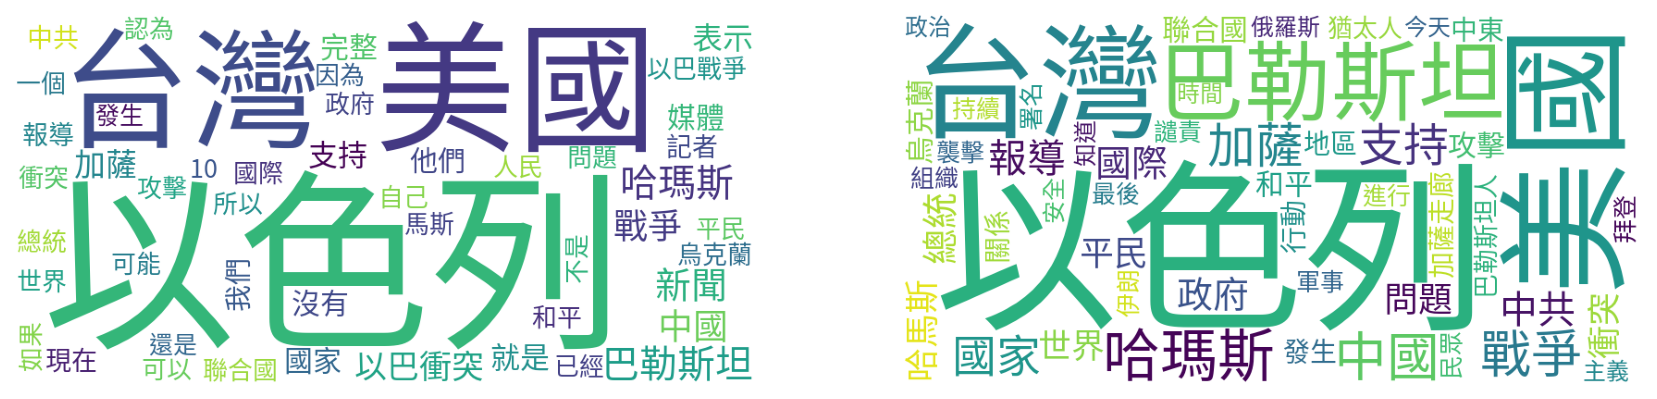

In [48]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wordcloud_after)
plt.axis('off')

plt.show()

## 2. 利用lexicon-base進行情緒分析

進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併。

In [49]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

word sentiments
0   ):     affect
1   3q     affect
2   :(     affect
3   :)     affect
4   <3     affect

情緒字典與斷詞結果進行合併

In [50]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

artUrl     artDate  \
0       https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   
1       https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   
2       https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   
3       https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   
4       https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   
...                                                   ...         ...   
139893  https://www.ptt.cc/bbs/HatePolitics/M.17114341...  2024-03-26   
139894  https://www.ptt.cc/bbs/HatePolitics/M.17114341...  2024-03-26   
139895  https://www.ptt.cc/bbs/HatePolitics/M.17114341...  2024-03-26   
139896  https://www.ptt.cc/bbs/HatePolitics/M.17114341...  2024-03-26   
139897  https://www.ptt.cc/bbs/HatePolitics/M.17114341...  2024-03-26   

                      artTitle  \
0            [問卦]遇到以巴衝突ing怎麼辦？   
1            [問卦]遇到以巴衝突ing怎麼辦？   
2            [問卦]遇到以巴衝突ing怎麼辦？   
3            [問卦]遇到以巴衝突ing怎麼辦？   
4            [問卦]遇到以巴衝突ing怎麼辦？   
...                        ...   
139893  [新聞]美國不擋了！　安理會首過加薩停火決議   
139894  [新聞]美國不擋了！　安理會首過加薩停火決議   
139895  [新聞]美國不擋了！　安理會首過加薩停火決議   
139896  [新聞]美國不擋了！　安理會首過加薩停火決議   
139897  [新聞]美國不擋了！　安理會首過加薩停火決議   

                                               artContent  word sentiments  
0       是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...  巴勒斯坦        NaN  
1       是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   控制區        NaN  
2       是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   希伯崙        NaN  
3       是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...    觀光        NaN  
4       是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...    一下        NaN  
...                                                   ...   ...        ...  
139893  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   哈馬斯        NaN  
139894  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   同路人        NaN  
139895  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...    美國        NaN  
139896  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   哈馬斯        NaN  
139897  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   同路人        NaN  

[139898 rows x 6 columns]

### 2.1 正負向情緒詞彙頻率折線圖

In [51]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

artDate sentiments  size
3    2022-02-25   negative     1
4    2022-02-25   positive     2
8    2022-02-26   negative     6
13   2022-08-07   negative     6
14   2022-08-07   positive     1
..          ...        ...   ...
655  2024-04-10   negative    15
656  2024-04-10   positive    18
662  2024-04-13   positive    30
661  2024-04-13   negative     5
665  2024-04-15   negative     1

[249 rows x 3 columns]

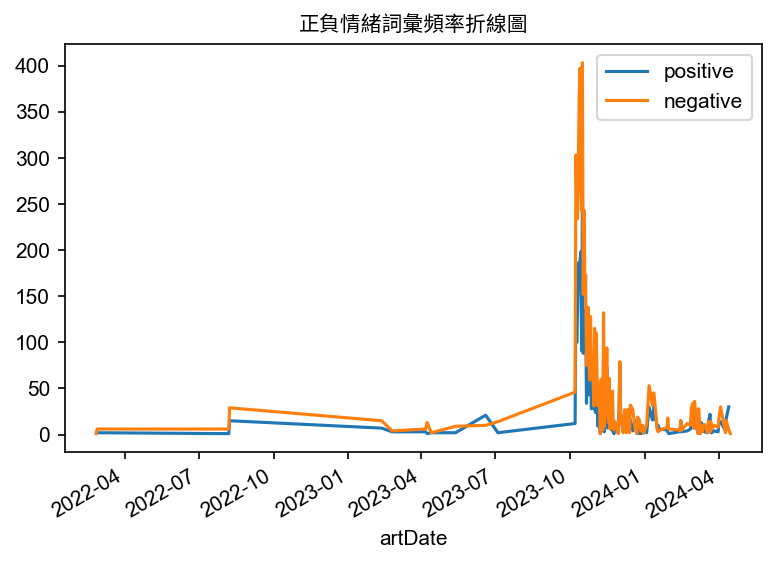

In [52]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

結論: 初期在八卦版討論以巴戰爭時，正負面詞彙的使用無太大的起伏，直到2023-10，版面開始出現大量的負面詞彙。於2.5的部分會深入探討這段時間發生了什麼事件或問題導致負面詞彙顯著增加。

但由於2023-10，有軍事行動的發生而導致正負向詞頻數隨之飆高，在趨勢圖看來可能會認為該區間的正負向情緒較為顯著，但也有可能是因為總體情緒詞彙本來就比較多而導致的。
因此接下來將以比例的方式來看，我們可以觀察到某個情緒詞在總體情緒詞彙中所佔的比例，就算某一天文章數相較多，也不會影響到比例的呈現。

### 2.2 正負向情緒詞彙比例折線圖圖

In [53]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

artDate sentiments  size     ratio
3    2022-02-25   negative     1  0.333333
4    2022-02-25   positive     2  0.666667
8    2022-02-26   negative     6  1.000000
13   2022-08-07   negative     6  0.857143
14   2022-08-07   positive     1  0.142857
..          ...        ...   ...       ...
655  2024-04-10   negative    15  0.454545
656  2024-04-10   positive    18  0.545455
662  2024-04-13   positive    30  0.857143
661  2024-04-13   negative     5  0.142857
665  2024-04-15   negative     1  1.000000

[249 rows x 4 columns]

In [54]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

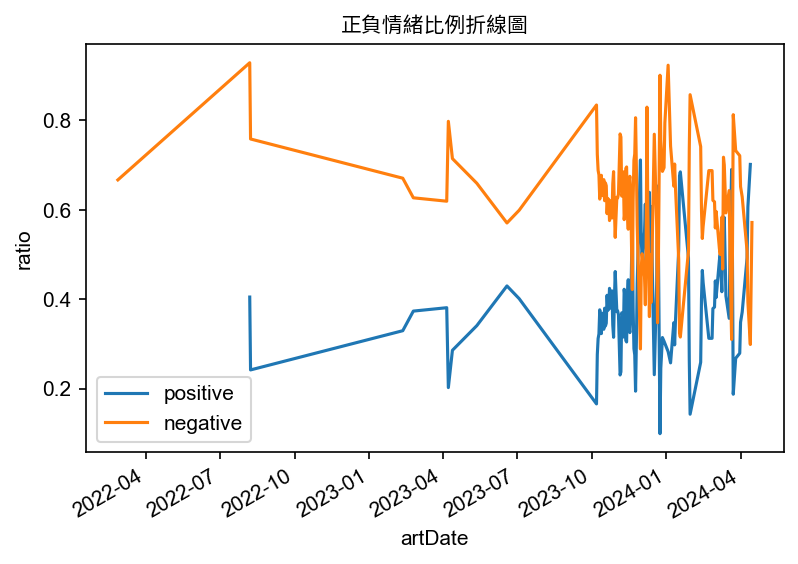

In [55]:
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 2 天平均
rolling_days = 2
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

畫出每天的情緒比例，可以看到負面的情緒幾乎每天都超過正面，是個氣氛較不和諧的討論版。

### 2.3 文章為單位的情緒分析

In [56]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article

artUrl sentiments  size
0     https://www.ptt.cc/bbs/Gossiping/M.1642780019....     affect     2
1     https://www.ptt.cc/bbs/Gossiping/M.1645750990....     affect     3
2     https://www.ptt.cc/bbs/Gossiping/M.1645750990....      anger     1
3     https://www.ptt.cc/bbs/Gossiping/M.1645750990....   negative     1
4     https://www.ptt.cc/bbs/Gossiping/M.1645750990....   positive     2
...                                                 ...        ...   ...
3834  https://www.ptt.cc/bbs/HatePolitics/M.17114341...      anger     6
3835  https://www.ptt.cc/bbs/HatePolitics/M.17114341...        anx     1
3836  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   negative    10
3837  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   positive     4
3838  https://www.ptt.cc/bbs/HatePolitics/M.17114341...        sad     2

[3839 rows x 3 columns]

In [57]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....     2.0    0.0  0.0   
1  https://www.ptt.cc/bbs/Gossiping/M.1645750990....     3.0    1.0  0.0   
2  https://www.ptt.cc/bbs/Gossiping/M.1645805743....     6.0    2.0  2.0   
3  https://www.ptt.cc/bbs/Gossiping/M.1659842782....     1.0    0.0  0.0   
4  https://www.ptt.cc/bbs/Gossiping/M.1659885825....     6.0    1.0  1.0   

   negative  positive  sad  
0       0.0       0.0  0.0  
1       1.0       2.0  0.0  
2       6.0       0.0  2.0  
3       0.0       1.0  0.0  
4       6.0       0.0  0.0

In [58]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....     2.0    0.0  0.0   
1  https://www.ptt.cc/bbs/Gossiping/M.1645750990....     3.0    1.0  0.0   
2  https://www.ptt.cc/bbs/Gossiping/M.1645805743....     6.0    2.0  2.0   
3  https://www.ptt.cc/bbs/Gossiping/M.1659842782....     1.0    0.0  0.0   
4  https://www.ptt.cc/bbs/Gossiping/M.1659885825....     6.0    1.0  1.0   

   negative  positive  sad  sentiment_value  
0       0.0       0.0  0.0              0.0  
1       1.0       2.0  0.0              1.0  
2       6.0       0.0  2.0             -6.0  
3       0.0       1.0  0.0              1.0  
4       6.0       0.0  0.0             -6.0

In [59]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

artUrl  affect  anger  anx  \
0    https://www.ptt.cc/bbs/Gossiping/M.1642780019....     2.0    0.0  0.0   
1    https://www.ptt.cc/bbs/Gossiping/M.1645750990....     3.0    1.0  0.0   
2    https://www.ptt.cc/bbs/Gossiping/M.1645805743....     6.0    2.0  2.0   
3    https://www.ptt.cc/bbs/Gossiping/M.1659842782....     1.0    0.0  0.0   
4    https://www.ptt.cc/bbs/Gossiping/M.1659885825....     6.0    1.0  1.0   
..                                                 ...     ...    ...  ...   
910  https://www.ptt.cc/bbs/HatePolitics/M.17091907...    39.0   10.0  0.0   
911  https://www.ptt.cc/bbs/HatePolitics/M.17102451...    15.0    3.0  2.0   
912  https://www.ptt.cc/bbs/HatePolitics/M.17109951...     9.0    2.0  0.0   
913  https://www.ptt.cc/bbs/HatePolitics/M.17111693...     4.0    3.0  0.0   
914  https://www.ptt.cc/bbs/HatePolitics/M.17114341...    14.0    6.0  1.0   

     negative  positive  sad  sentiment_value sentiment_class  
0         0.0       0.0  0.0              0.0              負向  
1         1.0       2.0  0.0              1.0              正向  
2         6.0       0.0  2.0             -6.0              負向  
3         0.0       1.0  0.0              1.0              正向  
4         6.0       0.0  0.0             -6.0              負向  
..        ...       ...  ...              ...             ...  
910      17.0      20.0  2.0              3.0              正向  
911       6.0       9.0  0.0              3.0              正向  
912       2.0       4.0  0.0              2.0              正向  
913       3.0       1.0  0.0             -2.0              負向  
914      10.0       4.0  2.0             -6.0              負向  

[915 rows x 9 columns]

In [60]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date
clear_df_sentiment

artUrl  \
0    https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
1    https://www.ptt.cc/bbs/Gossiping/M.1645750990....   
2    https://www.ptt.cc/bbs/Gossiping/M.1645805743....   
3    https://www.ptt.cc/bbs/Gossiping/M.1659841623....   
4    https://www.ptt.cc/bbs/Gossiping/M.1659842782....   
..                                                 ...   
982  https://www.ptt.cc/bbs/HatePolitics/M.17091907...   
983  https://www.ptt.cc/bbs/HatePolitics/M.17102451...   
984  https://www.ptt.cc/bbs/HatePolitics/M.17109951...   
985  https://www.ptt.cc/bbs/HatePolitics/M.17111693...   
986  https://www.ptt.cc/bbs/HatePolitics/M.17114341...   

                         artTitle     artDate     artPoster   artCatagory  \
0               [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21         forng     Gossiping   
1             [問卦]去年阿富汗今年烏克蘭明年？？？  2022-02-25       ig49999     Gossiping   
2        [問卦]以色列猶太可以打巴基,俄國不能打烏克蘭?  2022-02-26       bra6617     Gossiping   
3       [爆卦]以巴衝突，巴勒斯坦24死，以轟400枚飛彈  2022-08-07       win1130     Gossiping   
4    Re:[爆卦]以巴衝突，巴勒斯坦24死，以轟400枚飛彈  2022-08-07   around14358     Gossiping   
..                            ...         ...           ...           ...   
982        [新聞]拜登要求以色列就使用美國武器提供保證  2024-02-29   remprogress  HatePolitics   
983             [黑特]現在正在第三次世界大戰了吧  2024-03-12     puppyvivi  HatePolitics   
984                [討論]現在很像當年二戰前？  2024-03-21     kymco9999  HatePolitics   
985              [討論]恐怖份子跟俄羅斯要挺誰？  2024-03-23  oneyoung1121  HatePolitics   
986        [新聞]美國不擋了！　安理會首過加薩停火決議  2024-03-26        HisVol  HatePolitics   

                                            artContent  \
0    是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
1    如題\n\n現在美國支撐的勢力逐漸瓦解\n\n美國上個世紀幫太多國家打仗了\n\n以巴衝突 ...   
2    之前以色列打巴基斯坦,\n\n不讓巴勒斯坦民?齋月期間前往聖殿山祈禱\n\n爆發大規模衝突,...   
3    https://youtu.be/x2BgAVgAhCY\n希望「\n國際社會\n」能出來譴...   
4    看了一下這影片，這中天新聞的報導在畫面右方寫"巴基斯坦"加薩現場直擊。\n"巴基斯坦"有加薩...   
..                                                 ...   
982  1.新聞網址︰\nhttp://tinyurl.com/2s4dhz28\n2.新聞來源︰\...   
983  依照現在這個情況算是世界大戰吧\n從烏克蘭不可能投降那刻開始\n歐洲那幾個平常養尊處優的幾個...   
984  二戰前有些地方跟現在很像\n\n像是極端主義的崛起，中東、歐美的激進派崛起，包括被極左派激起...   
985  某些台灣人喜歡二分法。\n\n每次國際有人發生衝突台灣人就跟玩狼人殺一樣，通常會有兩個預言家...   
986  1.新聞網址︰\nhttps://news.tvbs.com.tw/world/243607...   

                                            artComment             e_ip  \
0    [{"cmtStatus": "→", "cmtPoster": "stayawesome"...     83.244.63.14   
1    [{"cmtStatus": "→", "cmtPoster": "bill403777",...  223.140.236.187   
2    [{"cmtStatus": "推", "cmtPoster": "saber0408", ...   104.200.129.85   
3    [{"cmtStatus": "→", "cmtPoster": "greensaru", ...    118.231.201.7   
4    [{"cmtStatus": "推", "cmtPoster": "randolph80",...    112.78.93.193   
..                                                 ...              ...   
982  [{"cmtStatus": "推", "cmtPoster": "grandwar", "...    101.12.45.141   
983  [{"cmtStatus": "→", "cmtPoster": "MrTaxes", "c...   49.216.251.236   
984  [{"cmtStatus": "推", "cmtPoster": "HenryLin123"...     42.77.44.163   
985  [{"cmtStatus": "→", "cmtPoster": "SunnyBrian",...              NaN   
986  [{"cmtStatus": "→", "cmtPoster": "DustToDust",...  223.137.152.252   

       insertedDate dataSource sentiment_class  
0    2022/1/22 1:03        ptt              負向  
1    2022/2/26 0:44        ptt              正向  
2    2022/2/26 1:04        ptt              負向  
3    2022/8/10 1:17        ptt             NaN  
4    2022/8/10 1:17        ptt              正向  
..              ...        ...             ...  
982   2024/3/1 1:41        ptt              正向  
983  2024/3/13 2:00        ptt              正向  
984  2024/3/22 1:38        ptt              正向  
985  2024/3/25 1:37        ptt              負向  
986  2024/3/27 2:17        ptt              負向  

[987 rows x 11 columns]

In [61]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

artDate sentiment_class  size
0    2022-01-21              負向     1
1    2022-02-25              正向     1
2    2022-02-26              負向     1
3    2022-08-07              正向     1
4    2022-08-07              負向     1
..          ...             ...   ...
175  2024-04-03              負向     1
176  2024-04-09              正向     1
177  2024-04-10              正向     1
178  2024-04-13              正向     1
179  2024-04-15              負向     1

[180 rows x 3 columns]

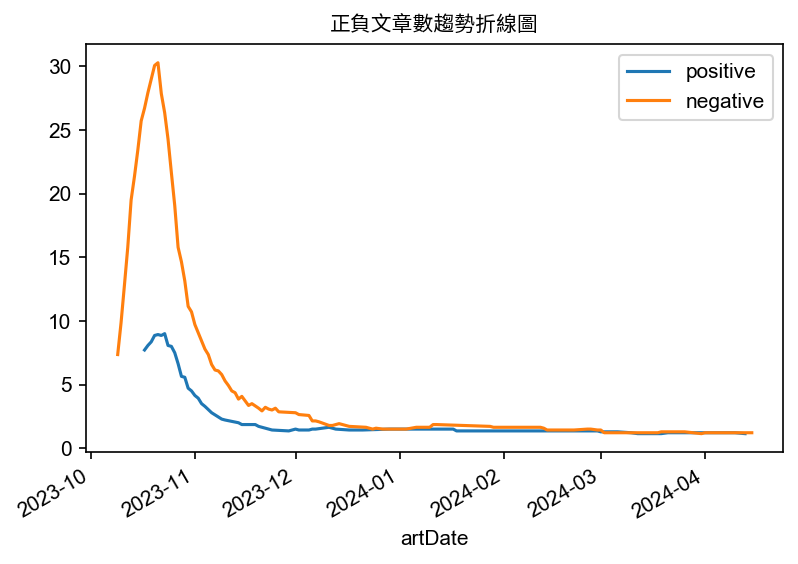

In [62]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

大部分文章都被歸類在負向文章，八卦版有關以巴討論內容大多偏負面

### 2.4 情緒代表字長條圖

In [63]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

word sentiments  size
960    戰爭   negative   713
958    戰爭     affect   713
959    戰爭      anger   713
1103   支持     affect   552
1104   支持   positive   552
...   ...        ...   ...
1213   欣賞     affect     1
1214   欣賞   positive     1
1219   歡愉     affect     1
1220   歡愉   positive     1
2120   鼻酸        sad     1

[2121 rows x 3 columns]

In [64]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

word sentiments  size
1104   支持   positive   552
436    和平   positive   259
628    安全   positive   175
689    希望   positive   132
1974   重要   positive   116
1809   解決   positive   110
1714   自由   positive    83
168    保護   positive    82
1279   決定   positive    71
1525   相信   positive    65
337    協助   positive    53
1998   關心   positive    52
943    成功   positive    50
2046   願意   positive    46
415    同情   positive    45

In [65]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

word sentiments  size
960    戰爭   negative   713
464    問題   negative   282
1787   衝突   negative   274
1119   攻擊   negative   265
1858   譴責   negative   178
1415   爆發   negative   145
1239   死亡   negative   142
357    反對   negative   114
511    嚴重   negative    98
252    八卦   negative    92
1855   警告   negative    78
1165   暴力   negative    68
615    威脅   negative    66
957    戰火   negative    64
247    入侵   negative    64

/var/folders/21/7y88t8cj1c3cjfvk2ww0y98h0000gn/T/ipykernel_13238/391454114.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
/var/folders/21/7y88t8cj1c3cjfvk2ww0y98h0000gn/T/ipykernel_13238/391454114.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

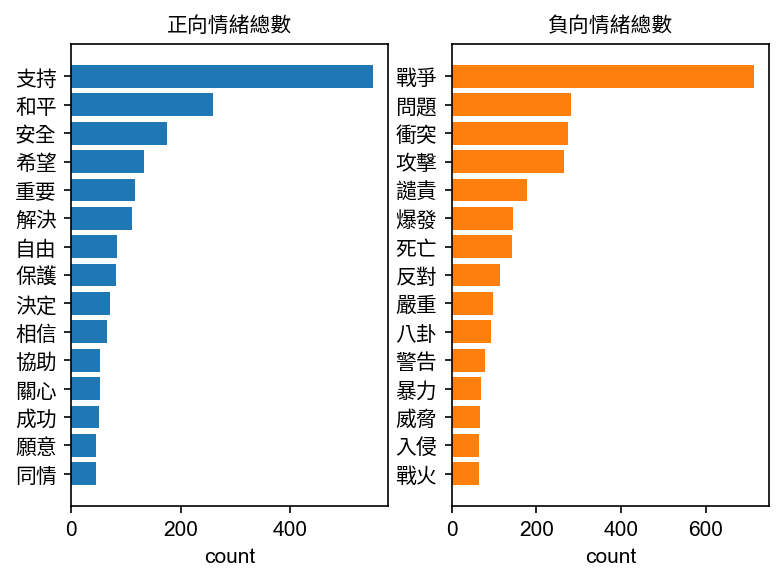

In [66]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

反覆檢查情緒詞是否符合本文本 (以「希望」為例)

In [67]:
filtered_df = sent_df[sent_df['sentence'].str.contains('希望', na=False)]
filtered_df.head()

artUrl  \
1102  https://www.ptt.cc/bbs/Gossiping/M.1696738597....   
1175  https://www.ptt.cc/bbs/Gossiping/M.1696746026....   
1180  https://www.ptt.cc/bbs/Gossiping/M.1696746026....   
1488  https://www.ptt.cc/bbs/Gossiping/M.1696765199....   
1489  https://www.ptt.cc/bbs/Gossiping/M.1696765199....   

                   artTitle     artDate  \
1102       [問卦]有必要以巴之間選邊站嗎？  2023-10-08   
1175    [問卦]以巴衝突，大家希望血流成河嗎？  2023-10-08   
1180    [問卦]以巴衝突，大家希望血流成河嗎？  2023-10-08   
1488  [問卦]看完俄烏和以巴戰爭大家還會想戰爭嗎  2023-10-08   
1489  [問卦]看完俄烏和以巴戰爭大家還會想戰爭嗎  2023-10-08   

                                             artContent  \
1102  就是這兩天的以巴衝突\n本來我以為只是單純的宗教衝突\n查了一下 好像不只這樣\n不管一開始...   
1175  1 不希望，只求雙方趕快弭平紛爭，盡快和平落幕，不要再造成更多死傷\n\n2 好耶好耶，希望...   
1180  1 不希望，只求雙方趕快弭平紛爭，盡快和平落幕，不要再造成更多死傷\n\n2 好耶好耶，希望...   
1488  如題\n\n 看完俄烏和以巴戰爭大家還會想戰爭嗎\n\n大家看了烏克蘭的踩地雷和躲兵役大賽\...   
1489  如題\n\n 看完俄烏和以巴戰爭大家還會想戰爭嗎\n\n大家看了烏克蘭的踩地雷和躲兵役大賽\...   

                                               sentence  
1102  就是這兩天的以巴衝突本來我以為只是單純的宗教衝突查了一下 好像不只這樣不管一開始衝突怎麼起來...  
1175                                              1 不希望  
1180                                             希望血流成河  
1488                                         會希望台灣也有戰爭嗎  
1489                                           希望全民上戰場嗎

In [68]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

就是這兩天的以巴衝突本來我以為只是單純的宗教衝突查了一下 好像不只這樣不管一開始衝突怎麼起來的到頭來兩邊都幹了不少骯髒事手腳都不乾淨其實沒有必要說誰對誰錯吧只希望平民的傷亡能越少越好
1 不希望
希望血流成河
會希望台灣也有戰爭嗎
希望全民上戰場嗎
以巴衝突 中國系網軍力挺巴勒斯坦 帶風向然後以色列下周開始對巴勒斯坦地區 展開地獄式血洗掃蕩國際沒人鳥巴勒斯坦民眾哀嚎  各國僅表示遺憾與希望和平  就這樣
希望能趕上最後一班飛往特拉維夫的班機
美國現在賣給我們的是希望打長久戰拖垮中國戰力
也希望療癒的力量
讓和平與希望回歸
希望中方在當前形勢下繼續發揮建設性作用
所以如果美日不希望海峽變內海
也不希望晶片技術被中國領先
他真的希望讓我們過上好日子
我真希望不是真的 News的女記者妮可
我真心希望這一切都不是真的
那整慘況讓她真希望一切都不是真的
中國希望被視為有責任感的大國
如果兩個災難讓你二選一你比較希望遇到哪個呢
不應該能承受這種痛希望孩子的爸爸媽媽要堅強根本沒有人性了
或是在公司死撐沒希望
目前以色列巴勒斯坦加薩走廊衝突雙方都希望對方下地獄
總是代表希望與光明
許多專家就認為前述交易達成希望渺茫
希望和平QQ回頭看巴勒斯坦那塊土地
希望對方為自己的損失負責
希望美方與中方相向而行
我希望此刻的衝突能呼籲國際社會正視巴勒斯坦問題
但馬斯克只說希望加薩電力及基本服務盡快恢復正常
他願意幫助那些希望加薩地區和平
並強調希望所有的人都幸福和繁榮
有關方面都希望推動停火止暴
以巴戰爭股板周末各個風聲鶴唳老黃這時來台灣 是多軍最後的希望嗎
我希望我們沒有走到這一步
但主持人沃克Kirsty Wark卻不斷希望他能出言譴責哈瑪斯
阿不就美國不想讓你台灣強 有自主能力 希望你當狗嗎 這不是事實
不希望台灣發展核武
中共就是希望爆發世界大戰
成為數以萬計迫切逃離加薩的人民的唯一希望
希望能取得允許向加薩地區運送救援物資
台積電各國都搶著要都希望台積電可以過去蓋晶片廠不止可以讓該國不缺晶片還可以提供就業機會讓附近的基礎建設大升級
歐美日大國都想方設法希望降低對台灣的半導體依賴
但這些國家的投票立場讓人懷疑其根本不希望安理會採取任何行動
不希望真正解決問題
團結一致帶來積極和希望
原本希望能夠搭乘這次的包機
美國總統拜登也希望自己在以巴衝突兩岸衝突間有些成就
對於希望離開加薩地區的

去除不符合文本的情緒詞：希望、成功、重要、願意、八卦、警告、朋友、清楚、同意
，並且重新計算情緒

In [69]:
# 設定要移除的字詞列表
words_to_remove = ['希望','成功','重要','願意','八卦','警告','朋友','清楚','同意','挑戰']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   
1  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   
2  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   
3  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   
4  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   

            artTitle                                         artContent  word  \
0  [問卦]遇到以巴衝突ing怎麼辦？  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...  巴勒斯坦   
1  [問卦]遇到以巴衝突ing怎麼辦？  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   控制區   
2  [問卦]遇到以巴衝突ing怎麼辦？  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   希伯崙   
3  [問卦]遇到以巴衝突ing怎麼辦？  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...    觀光   
4  [問卦]遇到以巴衝突ing怎麼辦？  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...    一下   

  sentiments  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

/var/folders/21/7y88t8cj1c3cjfvk2ww0y98h0000gn/T/ipykernel_13238/1465679712.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
/var/folders/21/7y88t8cj1c3cjfvk2ww0y98h0000gn/T/ipykernel_13238/1465679712.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

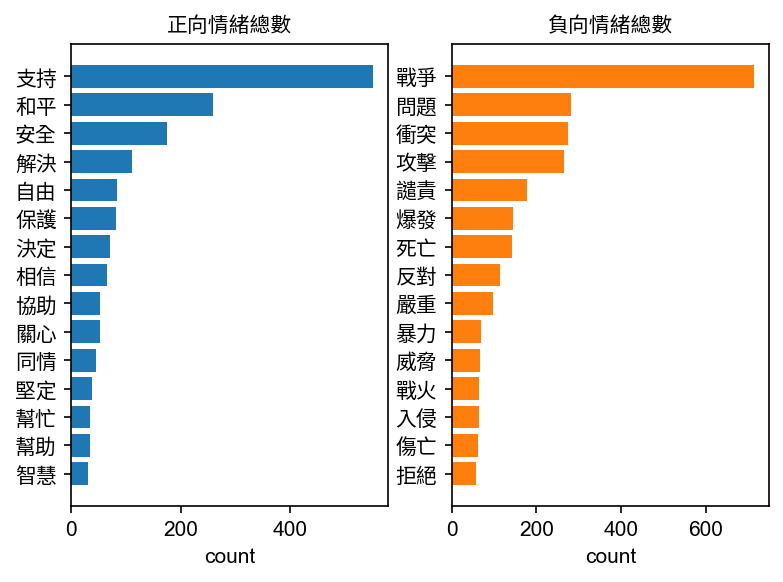

In [70]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

### 2.5 探討折線圖異常處(文字雲、字詞關係分析)

進一步篩選折線圖上面看起來聲量異常的地方（2023-10）。我們用文字雲來看一下這段時間出現了什麼關鍵字和字詞關係。

將前面計算出的文章情緒類別合併，以利我們過濾出負面文章資料

In [71]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   
1  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   
2  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   
3  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   
4  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  2022-01-21   

            artTitle                                         artContent  word  \
0  [問卦]遇到以巴衝突ing怎麼辦？  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...  巴勒斯坦   
1  [問卦]遇到以巴衝突ing怎麼辦？  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   控制區   
2  [問卦]遇到以巴衝突ing怎麼辦？  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   希伯崙   
3  [問卦]遇到以巴衝突ing怎麼辦？  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...    觀光   
4  [問卦]遇到以巴衝突ing怎麼辦？  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...    一下   

  sentiments sentiment_class  
0        NaN              負向  
1        NaN              負向  
2        NaN              負向  
3        NaN              負向  
4        NaN              負向

In [72]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

artUrl           artTitle  \
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   
1  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   
2  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   
3  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   
4  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   

      artDate                                         artContent  \
0  2022-01-21  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
1  2022-01-21  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
2  2022-01-21  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
3  2022-01-21  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
4  2022-01-21  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   

                       sentence sentiment_class  
0                          是這樣啦              負向  
1                      去巴勒斯坦控制區              負向  
2                    希伯崙想說來觀光一下              負向  
3                怎麼遇到民眾朝軍隊仍汽油彈啊              負向  
4  太刺激了吧 from JPTT on my iPhone              負向

In [74]:
date = "2023-10-01"
end_date = "2023-10-31"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc.head()

artUrl     artDate  \
1789  https://www.ptt.cc/bbs/Gossiping/M.1696668845....  2023-10-07   
1790  https://www.ptt.cc/bbs/Gossiping/M.1696668845....  2023-10-07   
1791  https://www.ptt.cc/bbs/Gossiping/M.1696668845....  2023-10-07   
1792  https://www.ptt.cc/bbs/Gossiping/M.1696668845....  2023-10-07   
1793  https://www.ptt.cc/bbs/Gossiping/M.1696668845....  2023-10-07   

            artTitle                                         artContent word  \
1789  [問卦]以巴衝突vs中台衝突  中國每年都說不放棄武力\n媽的只會共機繞台\n幹 講到我耳朵都長繭了\n到底什麼時候才會射火...   中國   
1790  [問卦]以巴衝突vs中台衝突  中國每年都說不放棄武力\n媽的只會共機繞台\n幹 講到我耳朵都長繭了\n到底什麼時候才會射火...   每年   
1791  [問卦]以巴衝突vs中台衝突  中國每年都說不放棄武力\n媽的只會共機繞台\n幹 講到我耳朵都長繭了\n到底什麼時候才會射火...   放棄   
1792  [問卦]以巴衝突vs中台衝突  中國每年都說不放棄武力\n媽的只會共機繞台\n幹 講到我耳朵都長繭了\n到底什麼時候才會射火...   放棄   
1793  [問卦]以巴衝突vs中台衝突  中國每年都說不放棄武力\n媽的只會共機繞台\n幹 講到我耳朵都長繭了\n到底什麼時候才會射火...   放棄   

     sentiments sentiment_class  
1789        NaN              負向  
1790        NaN              負向  
1791     affect              負向  
1792   negative              負向  
1793        sad              負向

In [75]:
date = "2023-10-01"
end_date = "2023-10-31"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

word  size
2472    以色列  1772
6642     戰爭  1188
4244    哈瑪斯   676
7399     攻擊   639
5755   巴勒斯坦   609
...     ...   ...
5860     幫打     1
5861     幫扶     1
5863     幫豬     1
5868     平叛     1
13807    龜著     1

[13808 rows x 2 columns]

**繪製2023-10月份的負面文章文字雲**

(-0.5, 799.5, 399.5, -0.5)

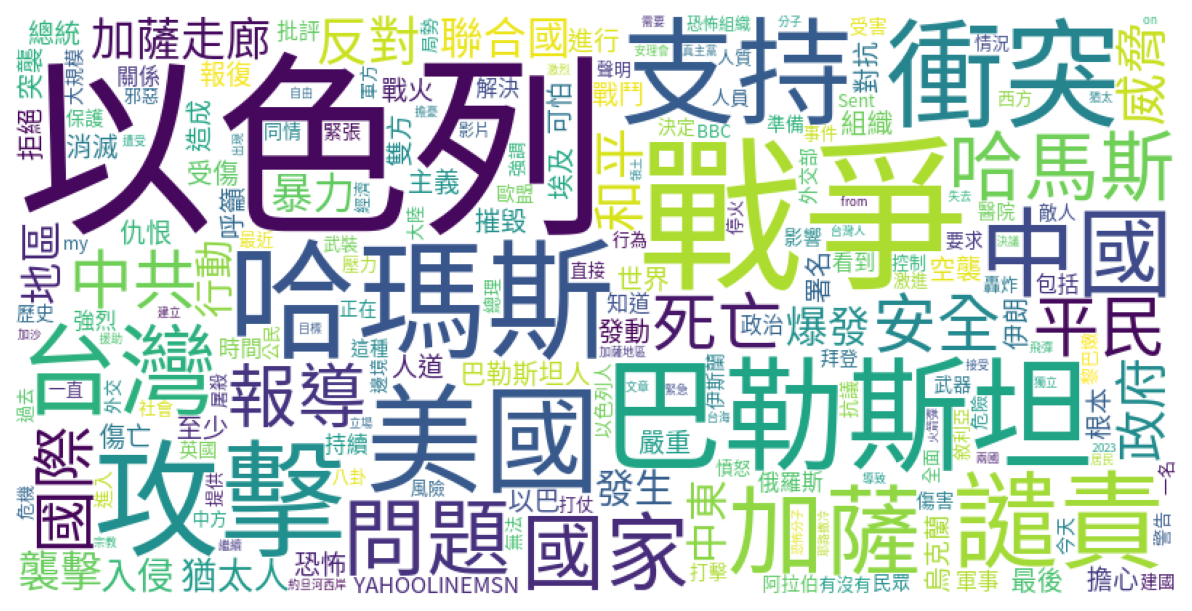

In [89]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, width=800, height = 400,background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize = (10,7))
plt.imshow(cloud)
plt.axis("off")
#plt.show()

關鍵字出現了「攻擊」、「戰爭」的關鍵字，可能是在說明期間內的頻繁衝突

**進一步繪製出2023-10月份包含「攻擊」的負面文章文字雲**

(-0.5, 799.5, 399.5, -0.5)

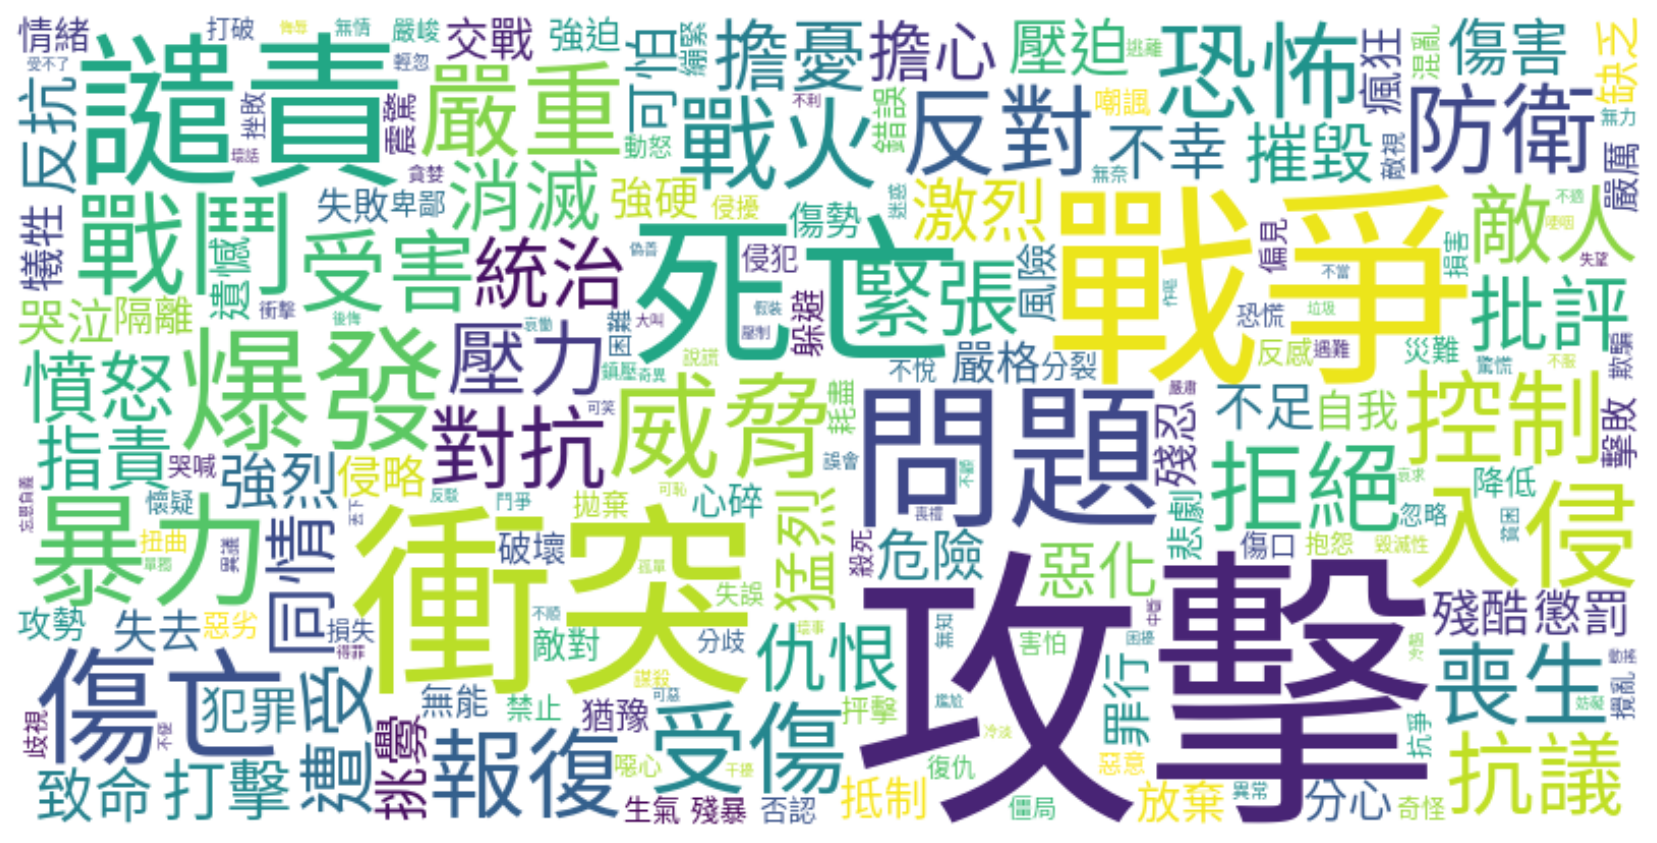

In [100]:
date = "2023-10-01"
end_date = "2023-10-31"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('攻擊')) & ( # 內文包含攻擊
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, width=800, height = 400,background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize = (14,8))
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

利用「問題」去查看原文內容

In [79]:
date = "2023-10-01"
end_date = "2023-10-31"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('攻擊')) & (
    sent_df['sentence'].str.contains('問題')) # 包含「問題」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df.head()

artUrl  \
1529  https://www.ptt.cc/bbs/Gossiping/M.1696781543....   
1530  https://www.ptt.cc/bbs/Gossiping/M.1696781543....   
1531  https://www.ptt.cc/bbs/Gossiping/M.1696781543....   
1532  https://www.ptt.cc/bbs/Gossiping/M.1696781543....   
1533  https://www.ptt.cc/bbs/Gossiping/M.1696781543....   

                     artTitle     artDate  \
1529  [新聞]以巴50年來最嚴重軍事危機：哈瑪斯大突  2023-10-09   
1530  [新聞]以巴50年來最嚴重軍事危機：哈瑪斯大突  2023-10-09   
1531  [新聞]以巴50年來最嚴重軍事危機：哈瑪斯大突  2023-10-09   
1532  [新聞]以巴50年來最嚴重軍事危機：哈瑪斯大突  2023-10-09   
1533  [新聞]以巴50年來最嚴重軍事危機：哈瑪斯大突  2023-10-09   

                                             artContent  \
1529  1.媒體來源:\n\n 《報導者》The Reporter\n\n2.記者署名:\n\n文字...   
1530  1.媒體來源:\n\n 《報導者》The Reporter\n\n2.記者署名:\n\n文字...   
1531  1.媒體來源:\n\n 《報導者》The Reporter\n\n2.記者署名:\n\n文字...   
1532  1.媒體來源:\n\n 《報導者》The Reporter\n\n2.記者署名:\n\n文字...   
1533  1.媒體來源:\n\n 《報導者》The Reporter\n\n2.記者署名:\n\n文字...   

                   sentence sentiment_class  
1529            哈瑪斯方面稱這次作戰為              負向  
1530  阿克薩指的是位於耶路撒冷舊城的阿克薩清真寺              負向  
1531         是穆斯林最重要的信仰聖地之一              負向  
1532        也是巴勒斯坦民族主義的精神象徵              負向  
1533      但同一位置也是猶太信仰所稱的聖殿山              負向

**結論**  
發現於2023-10的文章中有提到了巴勒斯坦「哈瑪斯」組織與「阿克薩」，而推測可能是這期間爆發了相關的衝突事件導致負面詞彙暴增，而事件經查證如下:

哈瑪斯於2023-10-07發動大規模攻擊行動，不但發射5千多枚土造火箭，更派出大批槍手攻克以色列軍方據點，綁架以國平民與士兵；並將這場大規模襲擊命名為「阿克薩風暴」行動，強調是為了捍衛清真寺而對以色列展開的報復。（取自新聞連結：https://www.upmedia.mg/news_info.php?Type=3&SerialNo=184178 ）


## 3.利用snowNLP進行情緒分析

### 3.1 情緒分數計算

In [107]:
from snownlp import SnowNLP

In [108]:
#運用前面斷句後的結果"sent_df"進行情緒分析
#去除不會用到的欄位
nlp_sent_df = sent_df.drop(['artUrl', 'artTitle', 'artContent'], axis=1)
nlp_sent_df.head(5)

artDate                      sentence
0  2022-01-21                          是這樣啦
1  2022-01-21                      去巴勒斯坦控制區
2  2022-01-21                    希伯崙想說來觀光一下
3  2022-01-21                怎麼遇到民眾朝軍隊仍汽油彈啊
4  2022-01-21  太刺激了吧 from JPTT on my iPhone

In [109]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
nlp_sent_df['sentimentValue'] = nlp_sent_df.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
nlp_sent_df.head(3)

artDate    sentence  sentimentValue
0  2022-01-21        是這樣啦        0.075836
1  2022-01-21    去巴勒斯坦控制區        0.522873
2  2022-01-21  希伯崙想說來觀光一下        0.263385

In [110]:
# 看一下情緒的分布
nlp_sent_df['sentimentValue'].describe()

count    2.869500e+04
mean     4.394760e-01
std      3.202742e-01
min      5.773160e-15
25%      1.362237e-01
50%      4.186047e-01
75%      7.189953e-01
max      1.000000e+00
Name: sentimentValue, dtype: float64

<Axes: >

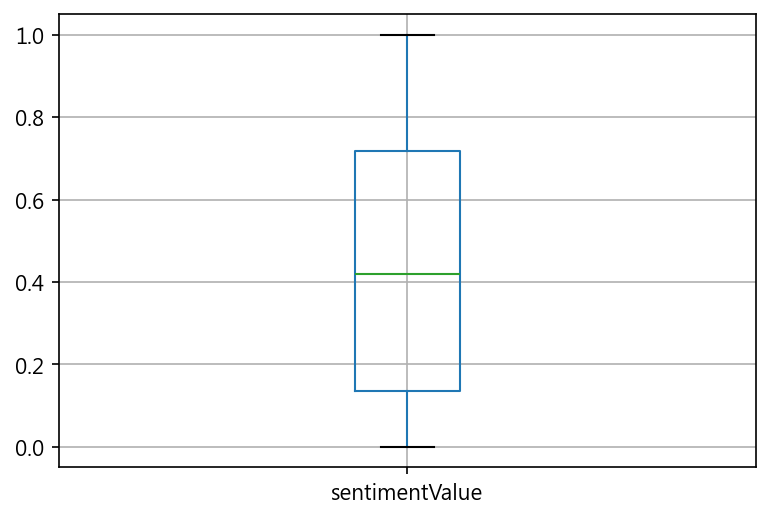

In [111]:
# 情緒分布的盒狀圖
boxplot = nlp_sent_df.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每個月的情緒分數取平均，並轉換時間格式為年月

In [112]:
sent_date = nlp_sent_df.copy()
sent_date['artDate'] =  pd.to_datetime(nlp_sent_df['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

artDate  sentimentValue
0   2022-01        0.407875
1   2022-02        0.558039
2   2022-08        0.467199
3   2023-02        0.499906
4   2023-04        0.460930
5   2023-05        0.410013
6   2023-06        0.528353
7   2023-07        0.351532
8   2023-10        0.440724
9   2023-11        0.418118
10  2023-12        0.452043
11  2024-01        0.492273
12  2024-02        0.401068
13  2024-03        0.442982
14  2024-04        0.433934

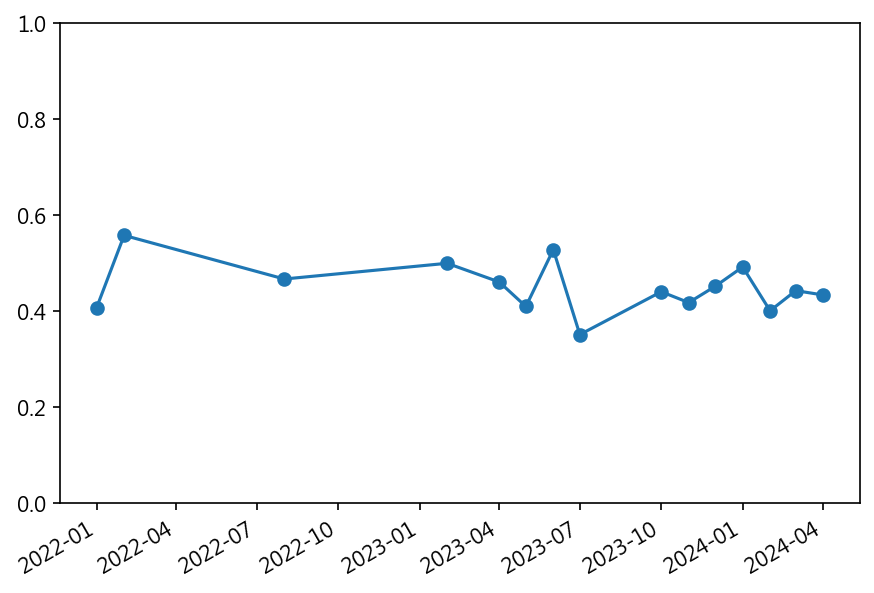

In [113]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

情緒值集中在0.4~0.6之間，整體在PTT八卦版的討論偏向中性。    

推測原因為:
- 以色列和巴勒斯坦的衝突是一個複雜且涵蓋多面向的問題，究竟以色列、巴基斯坦兩方誰對誰錯，並沒有一個明確的答案。這種複雜性可能使PTT八卦版的整體討論難以形成強烈或明確的意見。  

- PTT八卦版上多樣化的觀點：因為PTT八卦版上擁有各式各樣的用戶，每個用戶都以自己的觀點發表意見。這種觀點的多樣性可能導致正面、負面和中性**情感表達的混合**。

### 3.2 負面詞彙文字雲

根據上圖的觀察，我們發現2023年7月的情緒值僅有0.35，相對低，因此我們挑出它來分析。

把這個月情緒負面句子挑出來看看他們都用甚麼詞。

In [114]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2023-07']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.4]

filter_sentiment.head(10)

artDate                                    sentence  sentimentValue
337  2023-07                                   媒體 CNA中央社        0.024417
338  2023-07  以色列軍大舉突擊西岸北部城市哲寧 8巴勒斯坦人喪生 Netanyahu政府的這次行動        0.052367
340  2023-07                                      除無人機之外        0.083632
341  2023-07                               以軍還出動了推土機與裝甲車        0.007579
342  2023-07         頭戴巴拉克拉瓦頭套balaclava的巴勒斯坦槍手在警報聲中向以軍開火        0.066987
343  2023-07                             有些巴勒斯坦人則向以軍投擲石塊        0.133652
345  2023-07                        鄰近哲寧的難民營是巴勒斯坦武裝團體的據點        0.023005
348  2023-07                    以色列外交部長柯恩Eli Cohen告訴媒體記者        0.085098
353  2023-07                          超過2週前以軍襲擊哲寧難民營時的7人        0.127167
354  2023-07                             當時以軍罕見地從直升機發射飛彈        0.391372

In [115]:
#把2023-7月的句子進行斷詞
day_word_df = filter_sentiment.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
day_word_df = day_word_df.loc[day_word_df['word'].str.len() > 1]

day_word_df.head()

artDate  sentimentValue word
337  2023-07        0.024417   媒體
337  2023-07        0.024417  CNA
337  2023-07        0.024417  中央社
338  2023-07        0.052367  以色列
338  2023-07        0.052367   大舉

繪製負面詞彙文字雲

In [116]:
# 自定停用字
#我們直接在停用字典中加入 CNA、中央社
with open('dict/stopwords.txt', encoding='utf-8') as f:
    stop_words = f.read().splitlines()

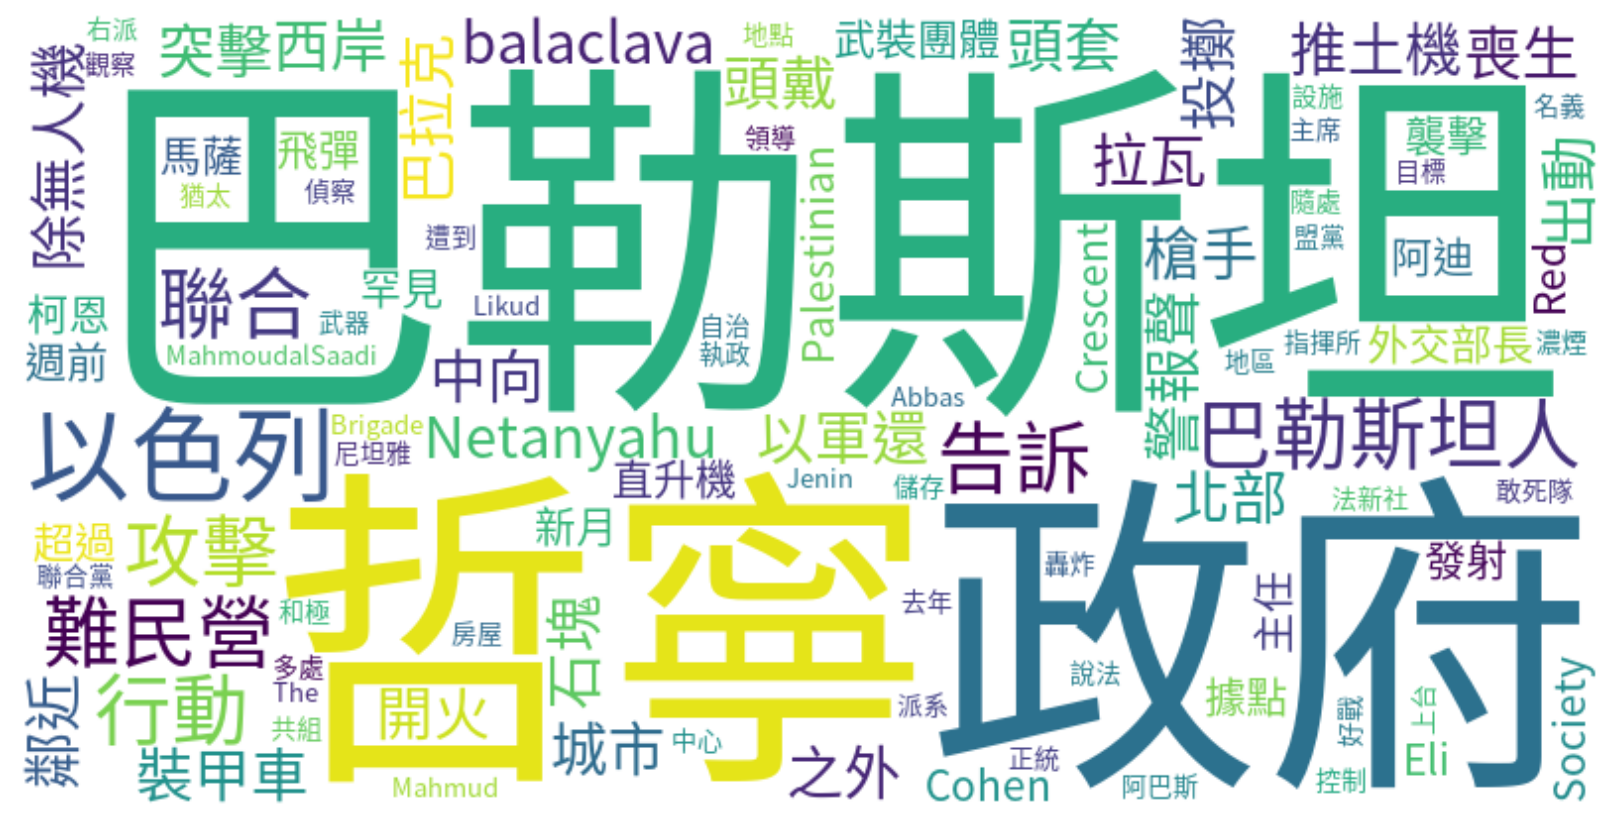

In [117]:
stop_words_pos = stop_words
stop_words_pos = set(stop_words_pos)
# 設定中文字形
font_path = 'SourceHanSansTW-Regular.otf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(day_word_df['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

可以看出負面詞彙文字雲出現了 **巴勒斯坦、政府、哲寧** 等詞彙，我們查詢2023-7 的新聞，發現了:  
- 以色列突襲哲寧難民營釀13死軍方宣布2天行動落幕
- 巴勒斯坦：以軍突襲西岸城市哲寧至少9死15傷  

......等與**哲寧**相關的關鍵字產生，推測應為該月哲寧難民營受到襲擊。所以情緒值才會較低。  

另外，我們也可以看到該月負面文章時常提及的詞彙包括: 難民營、行動、巴勒斯坦人、攻擊 .....等詞彙也時常被提及。

### 3.3 (補充) 使用 LLM Information Extraction 進行情緒分析


除了上述使用 lexicon-base 與 snowNLP 進行情緒分析外，本階段額外使用 HuggingFace 模型來實作情緒分析，以驗證各種方式的效果。  
詳細程式碼可以參考 **additional_llm.ipynb** 檔案。

## 4. 找出重要詞彙 - 以TF/IDF為例

### 4.1 TF/IDF

In [118]:
ptt_df_tfidf = df.copy()

# 去除一些不需要的欄位
ptt_df_tfidf = ptt_df_tfidf.drop(['artCatagory','artComment','e_ip','insertedDate','dataSource',], axis=1)

ptt_df_tfidf['artContent'] = ptt_df_tfidf['artContent'].astype(str)
# 只留下中文字
ptt_df_tfidf['sentence'] = ptt_df_tfidf['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

ptt_df_tfidf.head(3)

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
1  https://www.ptt.cc/bbs/Gossiping/M.1645750990....   
2  https://www.ptt.cc/bbs/Gossiping/M.1645805743....   

                   artTitle     artDate artPoster  \
0         [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21     forng   
1       [問卦]去年阿富汗今年烏克蘭明年？？？  2022-02-25   ig49999   
2  [問卦]以色列猶太可以打巴基,俄國不能打烏克蘭?  2022-02-26   bra6617   

                                          artContent  \
0  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
1  如題\n\n現在美國支撐的勢力逐漸瓦解\n\n美國上個世紀幫太多國家打仗了\n\n以巴衝突 ...   
2  之前以色列打巴基斯坦,\n\n不讓巴勒斯坦民?齋月期間前往聖殿山祈禱\n\n爆發大規模衝突,...   

                                            sentence  
0          是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧  
1  如題現在美國支撐的勢力逐漸瓦解美國上個世紀幫太多國家打仗了以巴衝突朝鮮越南從美國到現在美國的...  
2  之前以色列打巴基斯坦不讓巴勒斯坦民齋月期間前往聖殿山祈禱爆發大規模衝突有些網友還嘲笑巴基斯坦...

In [119]:
ip_df = ptt_df_tfidf.copy()
ip_df['system_id']= range (1,len(ip_df)+1)
ip_df.head()

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
1  https://www.ptt.cc/bbs/Gossiping/M.1645750990....   
2  https://www.ptt.cc/bbs/Gossiping/M.1645805743....   
3  https://www.ptt.cc/bbs/Gossiping/M.1659841623....   
4  https://www.ptt.cc/bbs/Gossiping/M.1659842782....   

                       artTitle     artDate    artPoster  \
0             [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21        forng   
1           [問卦]去年阿富汗今年烏克蘭明年？？？  2022-02-25      ig49999   
2      [問卦]以色列猶太可以打巴基,俄國不能打烏克蘭?  2022-02-26      bra6617   
3     [爆卦]以巴衝突，巴勒斯坦24死，以轟400枚飛彈  2022-08-07      win1130   
4  Re:[爆卦]以巴衝突，巴勒斯坦24死，以轟400枚飛彈  2022-08-07  around14358   

                                          artContent  \
0  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
1  如題\n\n現在美國支撐的勢力逐漸瓦解\n\n美國上個世紀幫太多國家打仗了\n\n以巴衝突 ...   
2  之前以色列打巴基斯坦,\n\n不讓巴勒斯坦民?齋月期間前往聖殿山祈禱\n\n爆發大規模衝突,...   
3  https://youtu.be/x2BgAVgAhCY\n希望「\n國際社會\n」能出來譴...   
4  看了一下這影片，這中天新聞的報導在畫面右方寫"巴基斯坦"加薩現場直擊。\n"巴基斯坦"有加薩...   

                                            sentence  system_id  
0          是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧          1  
1  如題現在美國支撐的勢力逐漸瓦解美國上個世紀幫太多國家打仗了以巴衝突朝鮮越南從美國到現在美國的...          2  
2  之前以色列打巴基斯坦不讓巴勒斯坦民齋月期間前往聖殿山祈禱爆發大規模衝突有些網友還嘲笑巴基斯坦...          3  
3               希望國際社會能出來譴責像俄羅斯一樣制裁這樣不人道的行為絕對要制止這種歪風          4  
4  看了一下這影片這中天新聞的報導在畫面右方寫巴基斯坦加薩現場直擊巴基斯坦有加薩嗎還有同意這位鄉...          5

In [120]:
# 設定繁體中文詞庫
jieba.set_dictionary('dict\dict.txt')

# 新增stopwords
with open('dict\stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [121]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [122]:
# 保留需要的欄位
ip_df = ip_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
ip_df['word'] = ip_df.sentence.apply(getToken).map(' '.join)
ip_df.head()


Building prefix dict from c:\Users\ASUS\Desktop\課程資料\2024春\社媒\SMA_2024S-main\SMA_2024S-main\sma_project0422\sma_project\dict\dict.txt ...
Loading model from cache C:\Users\ASUS\AppData\Local\Temp\jieba.u6c5d70386e8b08775873b6ac38e414e2.cache
Loading model cost 0.565 seconds.
Prefix dict has been built successfully.


system_id                                           sentence  \
0          1          是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧   
1          2  如題現在美國支撐的勢力逐漸瓦解美國上個世紀幫太多國家打仗了以巴衝突朝鮮越南從美國到現在美國的...   
2          3  之前以色列打巴基斯坦不讓巴勒斯坦民齋月期間前往聖殿山祈禱爆發大規模衝突有些網友還嘲笑巴基斯坦...   
3          4               希望國際社會能出來譴責像俄羅斯一樣制裁這樣不人道的行為絕對要制止這種歪風   
4          5  看了一下這影片這中天新聞的報導在畫面右方寫巴基斯坦加薩現場直擊巴基斯坦有加薩嗎還有同意這位鄉...   

                                                word  
0                 巴勒斯坦 控制區 希伯崙 觀光 一下 遇到 民眾 軍隊 汽油彈 刺激  
1  如題 美國 支撐 勢力 逐漸 瓦解 美國 上個 世紀 太多 國家 打仗 以巴 衝突 朝鮮 越...  
2  以色列 巴基斯坦 巴勒斯坦 齋月 期間 前往 聖殿山 祈禱 爆發 大規模 衝突 網友 嘲笑 ...  
3                 希望 國際 社會 譴責 俄羅斯 制裁 不人道 行為 制止 這種 歪風  
4  一下 影片 中天 報導 畫面 右方 巴基斯坦 加薩 現場 直擊 巴基斯坦 加薩 同意 這位 ...

In [123]:
# Bag of Word
vectorizer = CountVectorizer(max_features=1000)  # 限制特徵數量為1000
X = vectorizer.fit_transform(ip_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

一下  一位  一名  一堆  一場  一年  一次  一段  一直  一種  ...  香港  馬來西亞  馬克宏  馬文君  馬斯  馬英九  \
0     1   0   0   0   0   0   0   0   0   0  ...   0     0    0    0   0    0   
1     0   0   0   0   0   0   0   0   0   0  ...   0     0    0    0   0    0   
2     0   0   0   0   0   0   0   0   1   0  ...   0     0    0    0   0    0   
3     0   0   0   0   0   0   0   0   0   0  ...   0     0    0    0   0    0   
4     1   0   0   0   0   0   0   0   0   0  ...   0     0    0    0   0    0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..   ...  ...  ...  ..  ...   
982   0   1   0   0   0   0   0   0   2   0  ...   0     0    0    0   0    0   
983   1   0   0   4   0   0   0   0   1   0  ...   0     0    1    0   0    1   
984   0   0   0   0   0   0   0   0   1   0  ...   0     0    0    0   0    0   
985   0   0   0   0   0   0   0   0   0   0  ...   0     0    0    0   0    0   
986   0   0   0   0   0   0   0   0   0   0  ...   0     0    0    0   2    0   

     高層  高級  高雄  黎巴嫩  
0     0   0   0    0  
1     0   0   0    0  
2     0   0   0    0  
3     0   0   0    0  
4     0   0   0    0  
..   ..  ..  ..  ...  
982   0   0   0    0  
983   0   0   0    0  
984   0   0   0    0  
985   0   0   0    0  
986   0   0   0    0  

[987 rows x 1000 columns]

In [124]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

一下        一位   一名       一堆   一場   一年   一次   一段        一直   一種  ...  \
0    0.476649  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.000000  0.0  ...   
1    0.000000  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.000000  0.0  ...   
2    0.000000  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.157449  0.0  ...   
3    0.000000  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.000000  0.0  ...   
4    0.267224  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.000000  0.0  ...   
..        ...       ...  ...      ...  ...  ...  ...  ...       ...  ...  ...   
982  0.000000  0.042019  0.0  0.00000  0.0  0.0  0.0  0.0  0.058250  0.0  ...   
983  0.061403  0.000000  0.0  0.25025  0.0  0.0  0.0  0.0  0.051666  0.0  ...   
984  0.000000  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.124074  0.0  ...   
985  0.000000  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.000000  0.0  ...   
986  0.000000  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.000000  0.0  ...   

      香港  馬來西亞       馬克宏  馬文君        馬斯       馬英九   高層   高級   高雄  黎巴嫩  
0    0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
1    0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
2    0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
3    0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
4    0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
..   ...   ...       ...  ...       ...       ...  ...  ...  ...  ...  
982  0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
983  0.0   0.0  0.092699  0.0  0.000000  0.081651  0.0  0.0  0.0  0.0  
984  0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
985  0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
986  0.0   0.0  0.000000  0.0  0.106758  0.000000  0.0  0.0  0.0  0.0  

[987 rows x 1000 columns]

### 4.2 檢視結果

In [125]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

doc_id        一下        一位   一名       一堆   一場   一年   一次   一段        一直  \
0         1  0.476649  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.000000   
1         2  0.000000  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.000000   
2         3  0.000000  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.157449   
3         4  0.000000  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.000000   
4         5  0.267224  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.000000   
..      ...       ...       ...  ...      ...  ...  ...  ...  ...       ...   
982     983  0.000000  0.042019  0.0  0.00000  0.0  0.0  0.0  0.0  0.058250   
983     984  0.061403  0.000000  0.0  0.25025  0.0  0.0  0.0  0.0  0.051666   
984     985  0.000000  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.124074   
985     986  0.000000  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.000000   
986     987  0.000000  0.000000  0.0  0.00000  0.0  0.0  0.0  0.0  0.000000   

     ...   香港  馬來西亞       馬克宏  馬文君        馬斯       馬英九   高層   高級   高雄  黎巴嫩  
0    ...  0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
1    ...  0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
2    ...  0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
3    ...  0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
4    ...  0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
..   ...  ...   ...       ...  ...       ...       ...  ...  ...  ...  ...  
982  ...  0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
983  ...  0.0   0.0  0.092699  0.0  0.000000  0.081651  0.0  0.0  0.0  0.0  
984  ...  0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
985  ...  0.0   0.0  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  
986  ...  0.0   0.0  0.000000  0.0  0.106758  0.000000  0.0  0.0  0.0  0.0  

[987 rows x 1001 columns]

In [126]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

doc_id word     tfidf
0            1   一下  0.476649
1            2   一下  0.000000
2            3   一下  0.000000
3            4   一下  0.000000
4            5   一下  0.267224
...        ...  ...       ...
986995     983  黎巴嫩  0.000000
986996     984  黎巴嫩  0.000000
986997     985  黎巴嫩  0.000000
986998     986  黎巴嫩  0.000000
986999     987  黎巴嫩  0.000000

[987000 rows x 3 columns]

In [127]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

<ipython-input-127-605f4783d420>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


word  size
75    以色列   288
449    戰爭   172
0      一下   154
217    台灣   146
73     以巴   132
762    美國   131
657    瑪斯   111
26     中國   109
383  巴勒斯坦   105
1      一位    99

- 可以看到以色列、巴勒斯坦、以巴都顯現在列表上。
- 列表也出現了台灣、美國、中國等關鍵字，可能顯示以巴衝突會對台灣、中國與美國的關係會有一些影響。

## 5. 透過結巴斷詞與N-gram幫助建立斷詞字典

In [128]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

### 5.1 Bigram

In [129]:
ip_bigram = ptt_df_tfidf.copy()

#ip_bigram['sentence'] = ip_bigram['sentence'].astype(str)
ip_bigram["word"] = ip_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
ip_bigram = ip_bigram.explode('word')
ip_bigram.head()

artUrl           artTitle  \
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   

      artDate artPoster                                         artContent  \
0  2022-01-21     forng  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
0  2022-01-21     forng  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
0  2022-01-21     forng  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
0  2022-01-21     forng  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
0  2022-01-21     forng  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   

                                    sentence      word  
0  是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧  巴勒斯坦 控制區  
0  是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧   控制區 希伯崙  
0  是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧    希伯崙 觀光  
0  是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧     觀光 一下  
0  是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧     一下 遇到

統計最常出現的bigram組合

In [130]:
# 計算每個組合出現的次數
ip_bigram_count = ip_bigram['word'].value_counts().reset_index()

ip_bigram_count.sort_values('count', ascending=False).head(10)

word  count
0     以巴 衝突    708
1     以巴 戰爭    316
2     轉載 備註    149
3     俄烏 戰爭    146
4    支持 以色列    104
5  以色列 巴勒斯坦     94
6     戰爭 以巴     89
7    約旦河 西岸     89
8     組織 瑪斯     86
9     加薩 地區     86

- 列表中的「以巴衝突」、「以巴戰爭」皆已加入斷詞詞典
- 另外將列表中的「俄烏戰爭」、「約旦河西岸」、「哈瑪斯組織」、「加薩地區」也新增至斷詞詞典

### 5.2 Bigram視覺化

使用自建詞典

In [131]:
# 新增相關自定義字典
jieba.load_userdict('dict\ip_lexicon.txt')

In [132]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = ptt_df_tfidf.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

artUrl           artTitle  \
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   

      artDate artPoster                                         artContent  \
0  2022-01-21     forng  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
0  2022-01-21     forng  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
0  2022-01-21     forng  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   

                                    sentence  word  
0  是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧  巴勒斯坦  
0  是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧   控制區  
0  是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧   希伯崙

In [133]:
bigramudist = ptt_df_tfidf.copy()

bigramudist["word"] = bigramudist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramudist = bigramudist.explode('word')
bigramudist.dropna(subset = ['word'], axis=0, how='any', inplace=True)

bigramudist.head(3)

artUrl           artTitle  \
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....  [問卦]遇到以巴衝突ing怎麼辦？   

      artDate artPoster                                         artContent  \
0  2022-01-21     forng  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
0  2022-01-21     forng  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
0  2022-01-21     forng  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   

                                    sentence      word  
0  是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧  巴勒斯坦 控制區  
0  是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧   控制區 希伯崙  
0  是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧    希伯崙 觀光

In [134]:
bigramudist['word'] = bigramudist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramudist = FreqDist(bigramudist['word'].apply(lambda x: tuple(x.split(' '))))
bigramudist.most_common(5)

[(('轉載', '備註'), 149),
 (('俄烏', '戰爭'), 147),
 (('支持', '以色列'), 104),
 (('以色列', '巴勒斯坦'), 94),
 (('約旦河', '西岸'), 89)]

In [135]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramudist.most_common(50)}

In [136]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

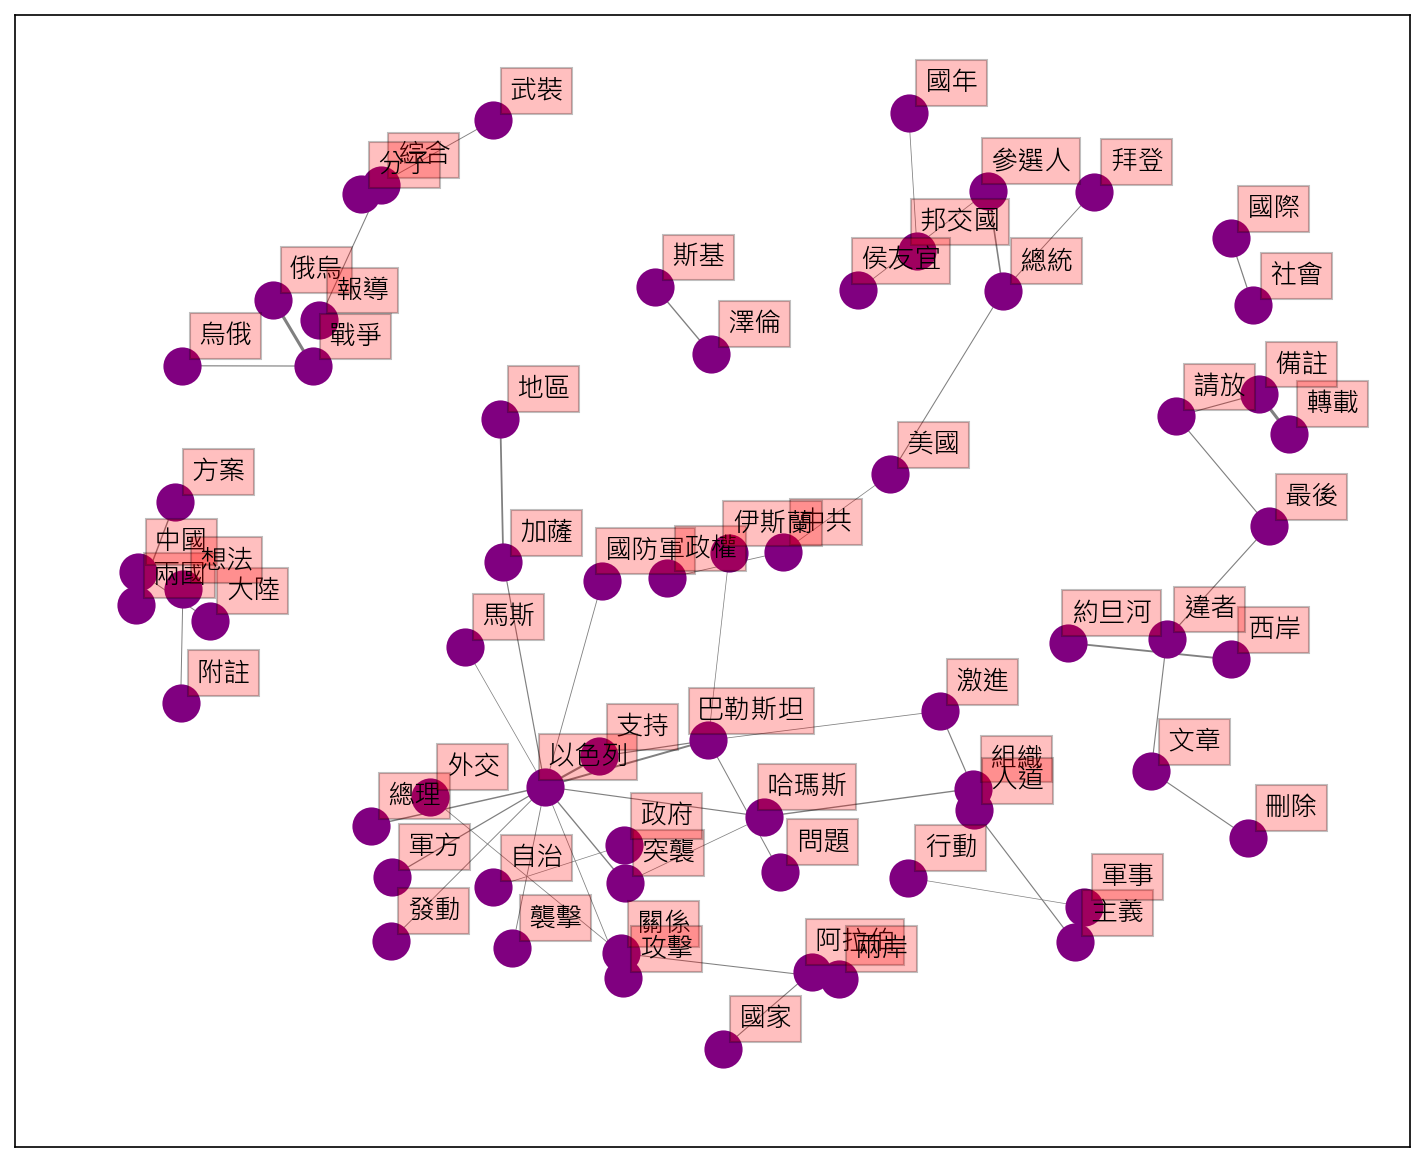

In [137]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

**網路圖分析**
- 左方顯示應有在探討中國對以巴衝突想法的文章
- 右方顯示應有探討約旦河西岸爆發的衝突的文章
- 左上方則是烏俄戰爭相關討論
- 而正中間則是整個以巴衝突事件的軸心，牽涉到加薩地區、以色列、巴勒斯坦、哈瑪斯組織與軍方、激進、軍事主義、國防等關鍵字
- 中上方出現烏克蘭總統澤倫斯基、美國總統拜登以及台灣的總統參選人侯友宜，應是有探討他們對以巴衝突立場的文章

## 6. Pairwise correlation

計算兩個詞彙間的相關性 Pearson correlation

In [168]:
data_cor = ptt_df_tfidf.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

artUrl  \
0  https://www.ptt.cc/bbs/Gossiping/M.1642780019....   
1  https://www.ptt.cc/bbs/Gossiping/M.1645750990....   
2  https://www.ptt.cc/bbs/Gossiping/M.1645805743....   

                   artTitle     artDate artPoster  \
0         [問卦]遇到以巴衝突ing怎麼辦？  2022-01-21     forng   
1       [問卦]去年阿富汗今年烏克蘭明年？？？  2022-02-25   ig49999   
2  [問卦]以色列猶太可以打巴基,俄國不能打烏克蘭?  2022-02-26   bra6617   

                                          artContent  \
0  是這樣啦\n\n去巴勒斯坦控制區，\n\n希伯崙想說來觀光一下\n\n怎麼遇到民眾朝軍隊仍汽...   
1  如題\n\n現在美國支撐的勢力逐漸瓦解\n\n美國上個世紀幫太多國家打仗了\n\n以巴衝突 ...   
2  之前以色列打巴基斯坦,\n\n不讓巴勒斯坦民?齋月期間前往聖殿山祈禱\n\n爆發大規模衝突,...   

                                            sentence  \
0          是這樣啦去巴勒斯坦控制區希伯崙想說來觀光一下怎麼遇到民眾朝軍隊仍汽油彈啊太刺激了吧   
1  如題現在美國支撐的勢力逐漸瓦解美國上個世紀幫太多國家打仗了以巴衝突朝鮮越南從美國到現在美國的...   
2  之前以色列打巴基斯坦不讓巴勒斯坦民齋月期間前往聖殿山祈禱爆發大規模衝突有些網友還嘲笑巴基斯坦...   

                                                word  
0                 巴勒斯坦 控制區 希伯崙 觀光 一下 遇到 民眾 軍隊 汽油彈 刺激  
1  如題 美國 支撐 勢力 逐漸 瓦解 美國 上個 世紀 太多 國家 打仗 朝鮮 越南 美國 美...  
2  以色列 巴基斯坦 巴勒斯坦 齋月 期間 前往 聖殿山 祈禱 爆發 大規模 衝突 網友 嘲笑 ...

In [169]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

一名  一直  不可能  不斷  世界  中共  中國  中心  中方  中東  ...  需要  面對  面臨  韓國  領土  領袖  顯示  \
0     0   0    0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
1     0   0    0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
2     0   1    0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
3     0   0    0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
4     0   0    0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
..   ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
982   0   2    0   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   1   
983   0   1    1   0   4   0   9   0   0   0  ...   0   0   0   0   0   0   0   
984   0   1    0   1   1   0   1   0   0   1  ...   0   0   0   0   0   0   0   
985   0   0    0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
986   0   0    0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

     飛彈  馬斯  黎巴嫩  
0     0   0    0  
1     0   0    0  
2     1   0    0  
3     0   0    0  
4     0   0    0  
..   ..  ..  ...  
982   0   0    0  
983   0   0    0  
984   0   0    0  
985   0   0    0  
986   0   2    0  

[987 rows x 300 columns]

In [170]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

word1        一名        一直       不可能        不斷        世界        中共  \
0      一名  1.000000  0.092188  0.098998  0.181901  0.035620  0.040688   
1      一直  0.092188  1.000000  0.191732  0.203482  0.189939  0.173599   
2     不可能  0.098998  0.191732  1.000000  0.204487  0.210777  0.045936   
3      不斷  0.181901  0.203482  0.204487  1.000000  0.277302  0.141969   
4      世界  0.035620  0.189939  0.210777  0.277302  1.000000  0.289156   
..    ...       ...       ...       ...       ...       ...       ...   
295    領袖  0.145324  0.070184  0.012574  0.032593  0.096889 -0.024560   
296    顯示  0.188348  0.041742 -0.028539  0.077186  0.095046  0.139872   
297    飛彈  0.011007  0.016964  0.038522  0.023767  0.007737 -0.002468   
298    馬斯  0.268897  0.154436  0.031438  0.084112  0.089427  0.356023   
299   黎巴嫩  0.034589  0.100906  0.012623  0.028473  0.066533  0.016473   

           中國        中心        中方  ...        需要        面對        面臨  \
0    0.002130  0.034361 -0.031241  ...  0.089159 -0.005555  0.007392   
1    0.190187  0.116346  0.144162  ...  0.141417  0.148119  0.009445   
2    0.202741  0.220772  0.037249  ...  0.249071  0.232656  0.011996   
3    0.093832  0.081691  0.084783  ...  0.098322  0.187914  0.056636   
4    0.278388  0.167707  0.024854  ...  0.266508  0.085938  0.145292   
..        ...       ...       ...  ...       ...       ...       ...   
295  0.055942  0.051692 -0.007440  ...  0.020502  0.017933  0.114881   
296  0.022657  0.166242 -0.021967  ...  0.051321  0.071129  0.133327   
297  0.038478  0.085362 -0.017325  ...  0.036207  0.057495  0.058354   
298  0.081221  0.103994  0.005670  ...  0.155510  0.042103  0.006774   
299 -0.010140  0.020262 -0.015663  ...  0.000695 -0.022150  0.075654   

           韓國        領土        領袖        顯示        飛彈        馬斯       黎巴嫩  
0   -0.024878 -0.006942  0.145324  0.188348  0.011007  0.268897  0.034589  
1    0.019634  0.120724  0.070184  0.041742  0.016964  0.154436  0.100906  
2    0.056099  0.074326  0.012574 -0.028539  0.038522  0.031438  0.012623  
3    0.065798  0.068343  0.032593  0.077186  0.023767  0.084112  0.028473  
4    0.081598  0.072568  0.096889  0.095046  0.007737  0.089427  0.066533  
..        ...       ...       ...       ...       ...       ...       ...  
295 -0.017800  0.046979  1.000000  0.099270  0.095683  0.078233  0.242477  
296 -0.001055  0.025806  0.099270  1.000000 -0.011503  0.309947 -0.004044  
297  0.100221  0.002553  0.095683 -0.011503  1.000000  0.063808  0.026952  
298  0.005817  0.030701  0.078233  0.309947  0.063808  1.000000  0.018292  
299 -0.007951  0.124324  0.242477 -0.004044  0.026952  0.018292  1.000000  

[300 rows x 301 columns]

In [174]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

word1 word2       cor
66549    西岸   約旦河  0.962139
74921   約旦河    西岸  0.962139
69864    轉載    署名  0.914384
79432    署名    轉載  0.914384
44110  中華民國    政權  0.911263
3147     政權  中華民國  0.911263
13355    方案    兩國  0.827100
46544    兩國    方案  0.827100
69637    備註    署名  0.824809
11332    署名    備註  0.824809

In [172]:
ip_sum = word_cor_df[(word_cor_df["word1"] == "衝突")].sort_values(by = ['cor'], ascending = False).head(10)
p_sum = word_cor_df[(word_cor_df["word1"] == "巴勒斯坦")].sort_values(by = ['cor'], ascending = False).head(10)

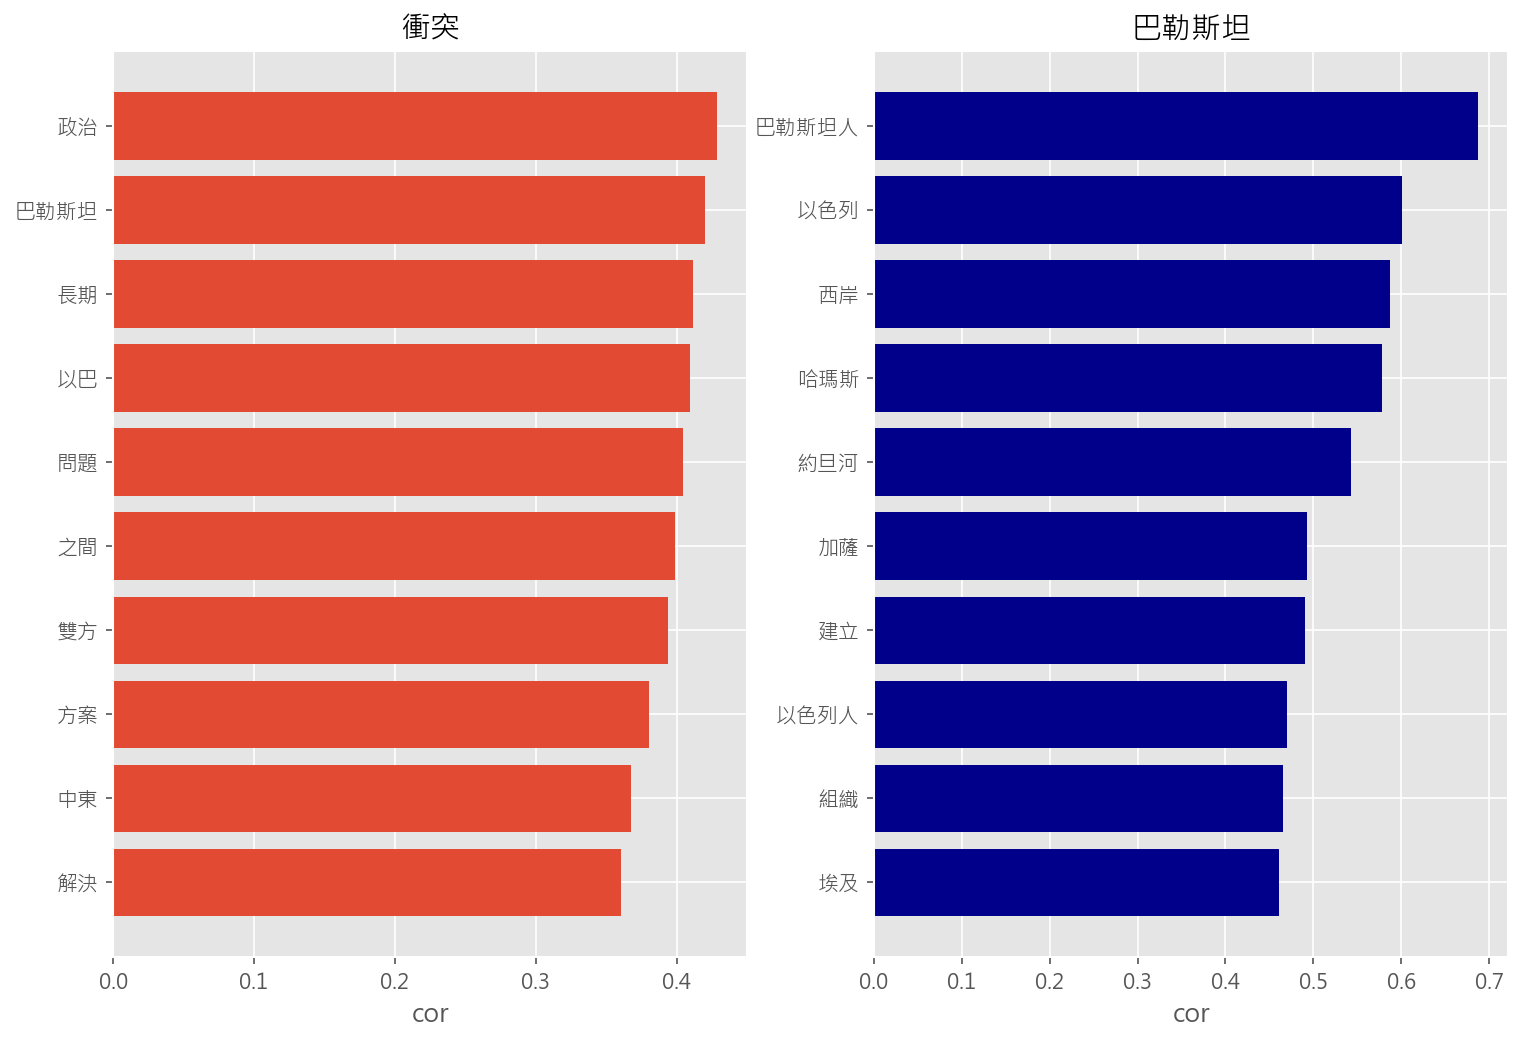

In [173]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('衝突')
plt.xlabel('cor')
plt.barh(ip_sum['word2'],ip_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('巴勒斯坦')
plt.xlabel('cor')
plt.barh(p_sum['word2'],p_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

- 「巴勒斯坦」的相關關鍵字出現「以色列」、「西岸」、「加薩」、「約旦河」、「哈瑪斯」，顯示了衝突對象、事件發生地區以及相關組織

### 6.1 使用詞彙關係圖畫出以詞頻前50為節點且相關性高於0.4的組合

In [162]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(50).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [163]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.4的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.4]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

word1 word2       cor
0      美國    中共  0.406163
1      關係    中共  0.452518
2      關係    中國  0.406293
3      加薩   以色列  0.562092
4    加薩走廊   以色列  0.429232
..    ...   ...       ...
117   民進黨    關係  0.552045
118    總統    關係  0.475793
119    美國    關係  0.487466
120   以色列    馬斯  0.550135
121    襲擊    馬斯  0.703549

[122 rows x 3 columns]

In [164]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

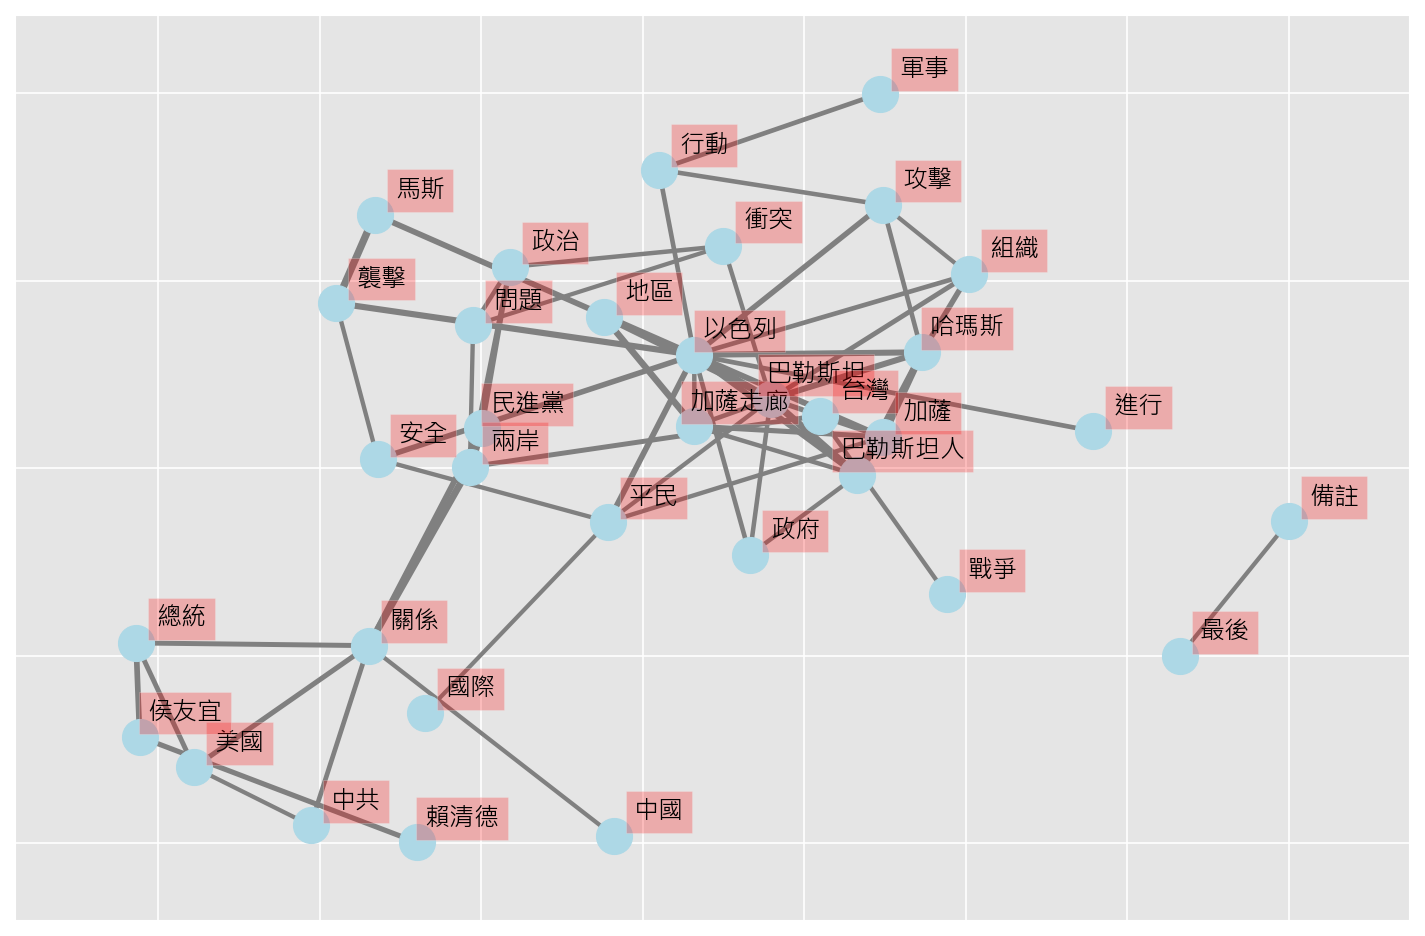

In [165]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.5)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()


- 圖中顯示除了探討事件發生的人事地物外，
PTT上也會討論到政治人物對此事件的立場及影響，
因此「賴清德」、「侯友宜」、「美國」、「中共」等詞彙都出現在圖表上了。

## 7. 建立Ngram預測模型

In [175]:
data3 = ptt_df_tfidf.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [176]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [177]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

預測下一個出現的詞

In [178]:
text = '巴勒斯坦'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 問題, probability: 0.0463
next word: 激進, probability: 0.0359
next word: 伊斯蘭, probability: 0.0331
next word: 以色列, probability: 0.0255
next word: 自治, probability: 0.0246


巴勒斯坦的預測詞出現了「激進」、「伊斯蘭」等詞彙，即是巴勒斯坦在以巴衝突事件當中的代表形象

In [179]:
text = '以色列'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 巴勒斯坦, probability: 0.0307
next word: 總理, probability: 0.0229
next word: 軍方, probability: 0.0193
next word: 加薩, probability: 0.0183
next word: 哈瑪斯, probability: 0.018


以色列的預測詞當中出現了「加薩」、「哈瑪斯」，顯示以色列對加薩走廊發動的攻勢，以及哈瑪斯組織屠殺以色列的事件描述

## 8. LDA 主題模型

本階段使用了 LDA主題模型 替文件進行分群，並使用Google Colab 進行呈現：  
https://colab.research.google.com/drive/1U04L1Je5OSO1099M26eI9mfamRjB8nVe?usp=sharing#scrollTo=YupJHcLA2H9S

## 9. BERT Text Clustering


本階段另外使用了 BERTopic 建立主題模型，並使用Google Colab 進行呈現：  
https://colab.research.google.com/drive/1ACJDB2BEaww8UNzh_zuCva-9zOVvU_B5#scrollTo=btaDgz0fwe2n

## 10. 使用NER結果繪圖

本階段使用了NER的結果，對實體進行分析並繪圖(Graph)觀察其中的關係，並Google Colab 進行呈現：  
https://colab.research.google.com/drive/1rLxDBdI7d3nL5eH0BvQvGL48-OAR87qU#scrollTo=6CWiLU15ECMB

## 11.  社群網路分析

本階針對PTT八卦版與政黑版之「以巴衝突議題」進行社群網路分析，並Google Colab 進行呈現：   
https://colab.research.google.com/drive/1PSfs6nR-xrg32bD3IsbI5OK81ukeLNgu#scrollTo=vf9-vNB3BB2H

## E. 總結

1. 透過觀察清理過後的文字雲，可以發現環繞以巴衝突的討論中，除了「以色列」、「巴基斯坦」外，相關詞彙的組織如「哈瑪斯」，國家如「美國」、「台灣」、「中國」，地區如「加薩」地帶的提及次數明顯較高，顯示了這些議題在討論中佔有重要地位，可能是討論的焦點和關注的中心。<br>

2. 經由觀察以情緒字典進行情緒分析、進一步生成的正負情緒詞彙頻率折線圖、正負情緒比例折線圖，可以發現PTT上關於以巴衝突的討論情緒偏向負面，尤其在巴勒斯坦武裝組織哈瑪斯發動軍事行動後，負面情緒更是有明顯飆高。<br>

3. 使用snowNLP進行情緒值分析，結果集中在0.4~0.6之間，呈現中性，我們推測可能是因為該議題的複雜性和PTT八卦版的多元觀點。而我們也針對情緒值僅有0.35的2023年7月進行分析，發現該月的負面詞彙文字雲出現了巴勒斯坦、政府、哲寧 等詞彙，推測應為該月哲寧難民營受到襲擊。所以情緒值才會較低。<br>

4. 我們透過TF/IDF找出重要詞彙，發現重要詞彙包括以色列、巴勒斯坦、台灣、美國、中國等關鍵字，反映了PTT上的討論者們對於以巴衝突對全球的影響較為關注。<br>

5. 觀察bigram網路圖，可以看出以巴衝突的討論所涵蓋的多種不同主題，如：中國對以巴衝突的想法、約旦河西岸爆發的衝突等等，並且也出現烏克蘭總統澤倫斯基、美國總統拜登以及台灣的總統參選人侯友宜等政治人物，應是有探討他們對以巴衝突立場的文章。<br>

6. 使用Pearson correlation計算詞彙間的相關性，我們發現「巴勒斯坦」的相關關鍵字出現「以色列」、「西岸」、「加薩」、「約旦河」、「哈瑪斯」，顯示了衝突對象、事件發生地區以及相關組織。<br>

7. 經由Ngram預測模型，巴勒斯坦的預測詞出現了「激進」、「伊斯蘭」等詞彙，以色列的預測詞當中則出現「加薩」、「哈瑪斯」。這反映了討論者們對於兩個當事國在以巴衝突中的形象和行動的感知，巴勒斯坦經常被描繪為擁有激進和伊斯蘭色彩的一方，而以色列則被描述為對加薩走廊發動攻勢，並受到哈瑪斯組織的攻擊。<br>

8. LDA vs BERT 查看主題分佈
    - 透過LDA模型分析PTT討論以巴衝突的主題，可以發現討論內容廣泛，涵蓋了以巴衝突事件本身、中國的立場、各國對衝突的觀點以及台灣政治與兩岸關係。這反映了PTT用戶對國際局勢和台灣自身政治情況的高度關注，並且在探討以巴衝突時，經常將其與台灣的政治和國際地位相聯繫，顯示出討論的多層次和複雜性。
    - 透過 BERT 分類會發現，PTT討論以巴衝突大致可以區分為三大主題，分別是以色列相關、國際相關、以及一個看不出主要主題的分群，分群效果沒有 LDA 來得好， LDA 分群能看出比較多資訊。

9. 透過 NER 結果繪製的圖(Graph)，可以幫助我們了解各組織、國家在以巴衝突中扮演的角色。我們也發現了在PTT上，以巴衝突的議題時常伴隨著台灣的政治議題一起討論，顯現出台灣網友對於國家的關心，並且因為台灣特殊的國際定位，使網友透過以巴衝突反思台灣的國際、國內政治局勢。另外，以巴衝突也牽動了美國政府、歐盟以及相關宗教團體的關注。

10. 根據社群網路圖，可以找出PTT上討論以巴戰爭的主要群體和扮演關鍵角色的網友。然而在這個議題中，用戶之間的關係較為鬆散、聯繫不緊密，較難形成穩定的社群網路，推測是因為文章來源的討論版、PTT為匿名的論壇以及缺乏能持續引導討論的意見領袖等原因造成。
